In [2]:
import sys
from pathlib import Path
from copy import deepcopy
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

try:
    if not(changed):
        raise Exception()
except:
    sys.path.append(str(Path(".").absolute().parent))
    changed = True

%load_ext autoreload
%autoreload 2

In [63]:
from notebooks.notebooks_utils import (oc20_to_graph, plot_element_3d, 
process_datapoint, get_activation, load_checkpoint,plot_atom_positions)

In [4]:
from sklearn.cluster import KMeans

def cluster_molecule_graph(x_processed):
    n_clusters = 5
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    _ = kmeans.fit_transform(x_processed.pos.detach().cpu().numpy())

    clusters = kmeans.labels_
    centers = kmeans.cluster_centers_
    distance_to_center = np.linalg.norm(x_processed.pos.detach().cpu().numpy() - centers[clusters], axis=1)

    j = 0
    nodes = np.arange(len(clusters))
    orders = np.zeros_like(clusters)
    for i in range(n_clusters):
        cluster_range = np.arange(j, j + (clusters == i).sum())
        orders[cluster_range] = nodes[clusters==i][np.argsort(distance_to_center[clusters == i])]
        j = j + (clusters == i).sum()

    plot_element_3d(data_graph, order=orders, clusters=clusters)

    return orders, clusters


In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib inline

plt.rc("animation", html="html5")

def plot_pca(model_name, base_activation, reorder=None):
    if reorder is None:
        reorder = np.arange(len(base_activation["InteractionBlock_0"]))
    key = "InteractionBlock_0"
    h = base_activation[key].cpu().numpy()[reorder]

    fig, ax = plt.subplots()

    pca = PCA(n_components=2)
    pca.fit(h)
    h_pca = pca.transform(h)
    # ax.scatter(h_pca[:, 0], h_pca[:, 1], c=np.arange(h_pca.shape[0]))
    ax.scatter(h_pca[:, 0], h_pca[:, 1], c=atomic_numbers)
    ax.set_title(f"{model_name} - PCA of hidden states")
    ax.set_ylabel(f"{key}")

    def update(key):
        if "EmbeddingBlock" in key: #only for faenet
            h = base_activation[key][0].cpu().numpy()[reorder]
        else:
            h = base_activation[key].cpu().numpy()[reorder]

        pca = PCA(n_components=2)
        pca.fit(h)
        h_pca = pca.transform(h)
        ax.clear()
        # ax.scatter(h_pca[:, 0], h_pca[:, 1], c=np.arange(h_pca.shape[0]))   
        ax.scatter(h_pca[:, 0], h_pca[:, 1], c=atomic_numbers)
        ax.set_title(f"{model_name} - PCA of hidden states")
        ax.set_ylabel(f"{key}")

        return ax
    
    ani = animation.FuncAnimation(fig, update, frames=list(base_activation.keys()), interval=1000)

    return ani


In [6]:
%matplotlib inline

plt.rc("animation", html="html5")

# compare the embeddings of the same atom in different blocks
def plot_embeddings(model_name, base_activation, reorder=None):
    if reorder is None:
        reorder = np.arange(len(base_activation["InteractionBlock_0"]))
    fig, ax = plt.subplots()

    for i in range(min(10, base_activation["InteractionBlock_0"].shape[0])):
        ax.plot(base_activation["InteractionBlock_0"][i, :].cpu().numpy()[reorder], label=f"Atom {i}", alpha=0.5)
    ax.set_xlabel("Hidden dimension")
    ax.set_ylabel("Activation")
    ax.set_title(f"{model_name} - Embeddings for atom {i}")
    ax.set(ylim=(-2, 2))
    ax.legend()

    def update(key):
        if "Embed" in key:
            h = base_activation[key][0].cpu().numpy()[reorder]
        else:
            h = base_activation[key].cpu().numpy()[reorder]
        ax.clear()
        for i in range(min(10, h.shape[0])):
            ax.plot(h[i, :], label=f"Atom {i}", alpha=0.5)
        ax.set_xlabel("Hidden dimension")
        ax.set_ylabel(f"{key}")
        ax.set_title(f"{model_name} - Embeddings for atom {i}")
        ax.set(ylim=(-3, 3))
        ax.legend()
        return ax
    
    ani = animation.FuncAnimation(fig, update, frames=list(base_activation.keys()), interval=1000)
    return ani


In [7]:
from collections import defaultdict

def plot_std_interactions(trainer, activations_dict, title="FAENet", type_="base"):
    activations_list = []
    train_loader = trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])

    with torch.no_grad():
        for i, x in enumerate(train_loader):
            if i == 1000:
                break
            # update activations_dict with new input
            base_output = trainer.model_forward(x)
            activations_list.append(deepcopy(activations_dict))

    blocks_std = defaultdict(list)
    blocks_mean = defaultdict(list)

    for activations_dict in activations_list:
        for i, (block, activations) in enumerate(activations_dict.items()):
            if "Embed" not in block:
                if type_ == "ewald":
                    if "Ewald" not in block:
                        # ignore non-ewald layers
                        continue
                    # plt.plot(activations[0].std(0).cpu().numpy(), label=block)
                    print()
                    blocks_std[block].append(activations[0].std(0).mean().cpu().numpy())
                    blocks_mean[block].append(activations[0].mean(0).mean(0).cpu().numpy())
                else:
                    if "Ewald" in block:
                        # ignore ewald layers
                        continue
                    # plt.plot(activations.std(0).cpu().numpy(), label=block)
                    blocks_std[block].append(activations.std(0).mean().cpu().numpy())
                    blocks_mean[block].append(activations.mean(0).mean(0).cpu().numpy())

    standard_deviations = [np.array(v) for v in blocks_std.values()]
    means = [np.array(v) for v in blocks_mean.values()]
    print(np.array(standard_deviations).shape)
    # take mean over batches
    standard_deviations = np.array(standard_deviations).mean(1)
    means = np.array(means).mean(1)

    plt.plot(standard_deviations)
    plt.title(f"{title} - Mean of Standard deviation for each block")
    plt.xlabel("Block")
    plt.ylabel("Mean of standard deviation")
    plt.show()

    plt.plot(means)
    plt.title(f"{title} - Mean of mean for each block")
    plt.xlabel("Block")
    plt.ylabel("Mean of mean")
    plt.show()

In [8]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

sns.set_theme()

"""def plot_similarity_matrix(activations_dict, orders=None, type_="base"):
    if orders is None:
        orders = np.arange(len(activations_dict["InteractionBlock_0"]))

    fig, axs = plt.subplots(2, 3, figsize=(15, 7))

    i = -1
    for key, embedding_step in activations_dict.items():
        if type_ == "ewald":
            if "Ewald" not in key and "Embed" not in key:
                continue
        else:
            if "Ewald" in key:
                continue
        i += 1
        ax = axs[i // 3, i % 3]
        try:
            h = embedding_step.detach().cpu().numpy()[orders]
        except:
            h = embedding_step[0].detach().cpu().numpy()[orders]

        cosine_similarity_matrix = cosine_similarity(h, h)
        ax.set_title(f"Similarity matrix for {key}")
        sns.heatmap(cosine_similarity_matrix, ax=ax, cmap="viridis")
    fig.tight_layout()
    fig.show()"""

In [55]:
def plot_similarity_matrix(activations_dict, title='FAENet', orders=None, type_="base"):
    # Determine the order of nodes if not provided
    if orders is None:
        orders = np.arange(len(activations_dict["InteractionBlock_0"]))
    
    # Filter keys based on type
    filtered_keys = [key for key in activations_dict.keys() if ("Ewald" in key if type_ == "ewald" else "Ewald" not in key)]

    # Determine the size of the grid
    n_plots = len(filtered_keys)
    n_cols = 3  # You can adjust the number of columns based on your preference
    n_rows = (n_plots + n_cols - 1) // n_cols  # Calculate rows needed

    # Create subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    axs = axs.flatten()  # Flatten the array of axes for easier indexing

    # Plot each matrix
    for i, key in enumerate(filtered_keys):
        embedding_step = activations_dict[key]
        try:
            h = embedding_step.detach().cpu().numpy()[orders]
        except:
            h = embedding_step[0].detach().cpu().numpy()[orders]

        cosine_similarity_matrix = cosine_similarity(h, h)
        axs[i].set_title(f"{key}")
        sns.heatmap(cosine_similarity_matrix, ax=axs[i], cmap="viridis")
    
    # Hide unused axes if any
    for j in range(i + 1, len(axs)):
        axs[j].axis('off')
    
    fig.suptitle(f"Similarity matrices throughout interaction layers for {title}", fontsize=16)
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)  # Adjust the top to make room for the suptitle
    plt.show()

In [9]:
def compute_mad(activations):
    """
    Compute the Mean Average Distance (MAD) for a single layer's activations.

    Parameters:
    activations (np.array or torch.Tensor): The activations of a single layer, where each row represents a node.

    Returns:
    float: The MAD value for the given layer of activations.
    """
    if not isinstance(activations, np.ndarray):
    # activations can be a tuple depending on embed or interaction block
        try:
            activations = activations.detach().cpu().numpy()
        except:
            activations = activations[0].detach().cpu().numpy()
    
    cosine_dist_matrix = 1 - cosine_similarity(activations)
    # distance of node to itself is zero, hence (len(activations) - 1
    avg_distances = np.sum(cosine_dist_matrix, axis=1) / (len(activations) - 1)
    mad_score = np.mean(avg_distances)
    return mad_score


In [43]:
def plot_mad_interactions(trainer, activations_dict, nb_batches=50, title="GNN MAD", type_="base"):
    """
    Collects activations across batches and plots the Mean Average Distance (MAD) across interaction layers.

    Parameters:
    trainer (object): Trainer object with methods to fetch data and compute forward passes.
    activations_dict (dict): Dictionary storing initial layer activations, updated on each forward pass.
    title (str): Title for the plot.
    type_ (str): Type of interaction to analyze, defaults to 'base'.
    """
    activations_list = []
    train_loader = trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])

    with torch.no_grad():
        for i, x in tqdm(enumerate(train_loader),desc='collecting data'):
            if i == nb_batches:
                break
            trainer.model_forward(x)
            activations_list.append(deepcopy(activations_dict))
    # print(f"nb of batches: {len(activations_list)}")
    blocks_mad = defaultdict(list)

    # Calculate MAD for each block across batches
    for activations_dict in activations_list:
        for block, activations in activations_dict.items():
            if "Embed" in block:
                continue  # Focusing only on interaction layers not labeled with 'Embed'
            mad_score = compute_mad(activations)
            blocks_mad[block].append(mad_score)

    # Prepare data for plotting
    mad_means = {block: np.mean(mads) for block, mads in blocks_mad.items()}
    blocks = list(mad_means.keys())
    print("blocks",blocks)
    mad_values = list(mad_means.values())
    print("mad_values",mad_values)

    # Plotting MAD across different blocks
    plt.figure(figsize=(7, 4))
    plt.bar(blocks, mad_values, color='skyblue')
    plt.title(f"{title} - Mean Average Distance (MAD) per Interaction Layer")
    plt.xlabel("Interaction Blocks")
    plt.ylabel("Mean Average Distance (MAD)")
    plt.xticks(rotation=45)  # Rotate block names for better visibility
    plt.tight_layout()
    plt.show()

In [45]:
def setup_and_plot_graph(job_id, graph_idx,plot=True):
    """
    Initializes a trained model from a checkpoint, sets up a data loader, registers forward hooks for activation
    collection, processes and plots a specific graph by index, fills the activation_dict with forward pass
    of this graph.

    Args:
    job_id (str): Identifier for the model checkpoint to load.
    graph_idx (int): Index of the graph in the dataset to process, plot, fill activations_dict.

    Returns:
    tuple: A tuple containing the trainer object, data loader, activations dictionary, and the output from the
           model forward pass for the specified graph index. Returns None if the specified index is out of range.
    """
    trainer = load_checkpoint(job_id)
    train_loader = trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])
    activations_dict = {}
    trainer.model.module.embed_block.register_forward_hook(get_activation(f"{trainer.model.module.embed_block.__class__.__name__}", activations_dict))
    for i, block in enumerate(trainer.model.module.interaction_blocks):
        block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict))

    with torch.no_grad():
        for i, x in enumerate(train_loader):
            if i == graph_idx:
                data_graph = oc20_to_graph(x[0], processed=False)
                if plot: plot_element_3d(data_graph)

                x_processed = process_datapoint(x[0], trainer)
                data_graph_processed = oc20_to_graph(x_processed)
                
                if plot: plot_element_3d(data_graph_processed)

                base_output = trainer.model_forward(x)
                
                return trainer, train_loader, activations_dict, base_output

    print(f"No batch found with index {graph_idx}. Ensure the correct index is provided.")
    return None

## Faenet and Schnet ewald

In [ ]:
job_id = "4344494" # faenet

trainer = load_checkpoint(job_id)
train_loader = trainer.get_dataloader(trainer.datasets["train"], trainer.samplers["train"])

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

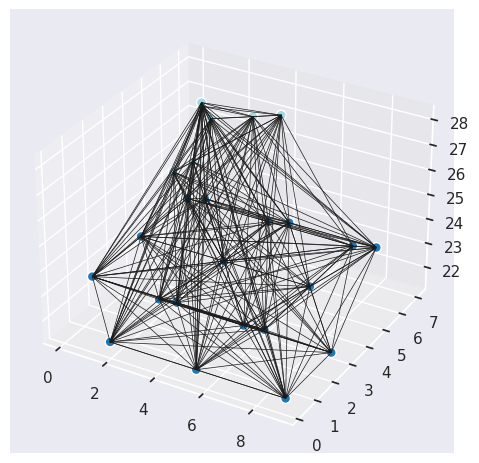

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

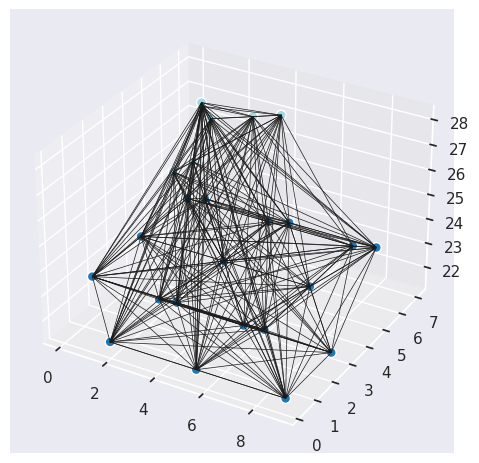

In [ ]:
activations_dict = {}

trainer.model.module.embed_block.register_forward_hook(get_activation(f"{trainer.model.module.embed_block.__class__.__name__}", activations_dict))

for i, block in enumerate(trainer.model.module.interaction_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict))

with torch.no_grad():
    for i, x in enumerate(train_loader):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0], trainer)
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = trainer.model_forward(x)

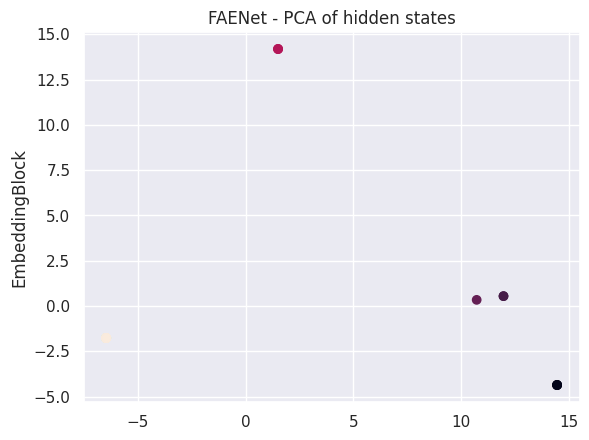

In [ ]:
ani = plot_pca("FAENet", activations_dict)
ani

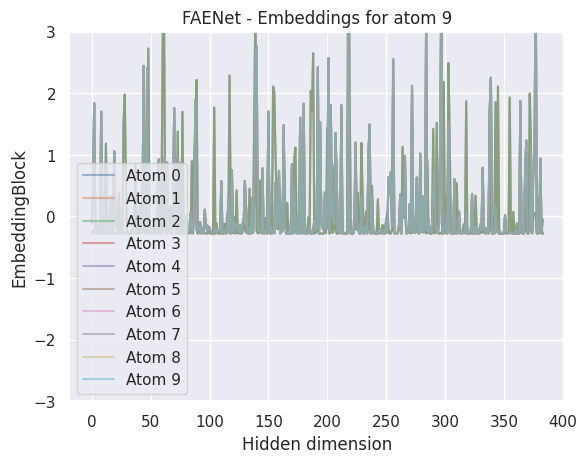

In [ ]:
ani = plot_embeddings("FAENet", activations_dict, reorder=None)
ani

(5, 10)


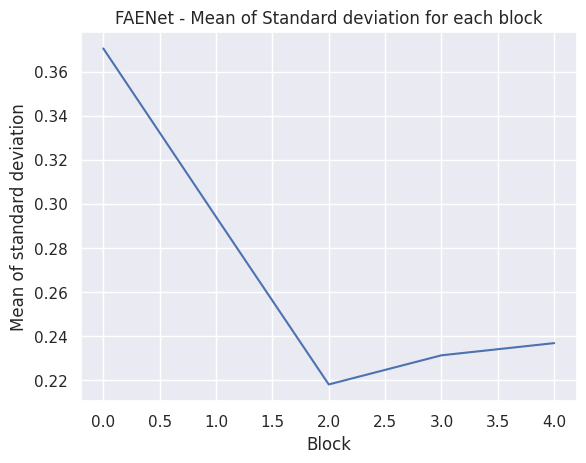

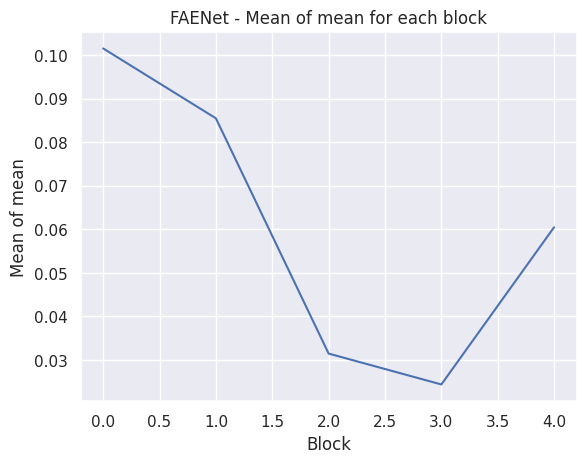

In [ ]:
plot_std_interactions(trainer, activations_dict)

In [ ]:
plot_similarity_matrix(activations_dict, None)

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

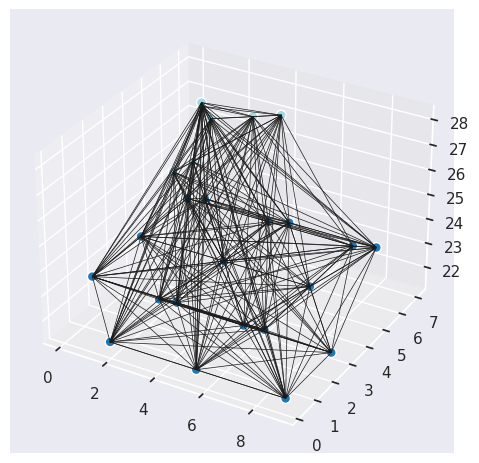

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

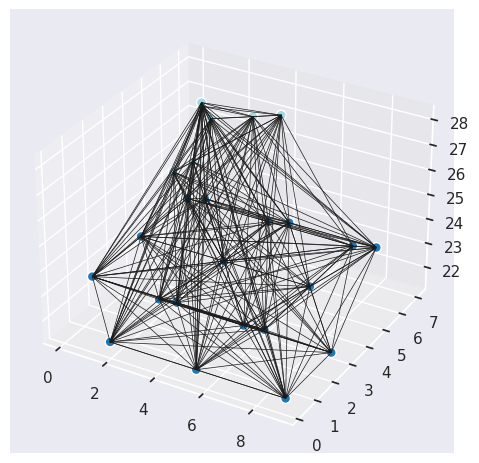

In [ ]:
# job_id = "4123618" #schnet
job_id = "4123617" #schnet

trainer_schnet = load_checkpoint(job_id)
train_loader_schnet = trainer_schnet.get_dataloader(trainer_schnet.datasets["train"], trainer_schnet.samplers["train"])

activations_dict_schnet = {}

trainer_schnet.model.module.embedding.register_forward_hook(get_activation(f"{trainer_schnet.model.module.embedding.__class__.__name__}", activations_dict_schnet))

for i, block in enumerate(trainer_schnet.model.module.interactions):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict_schnet))

with torch.no_grad():
    for i, x in enumerate(train_loader_schnet):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0], trainer_schnet)
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = trainer_schnet.model_forward(x)

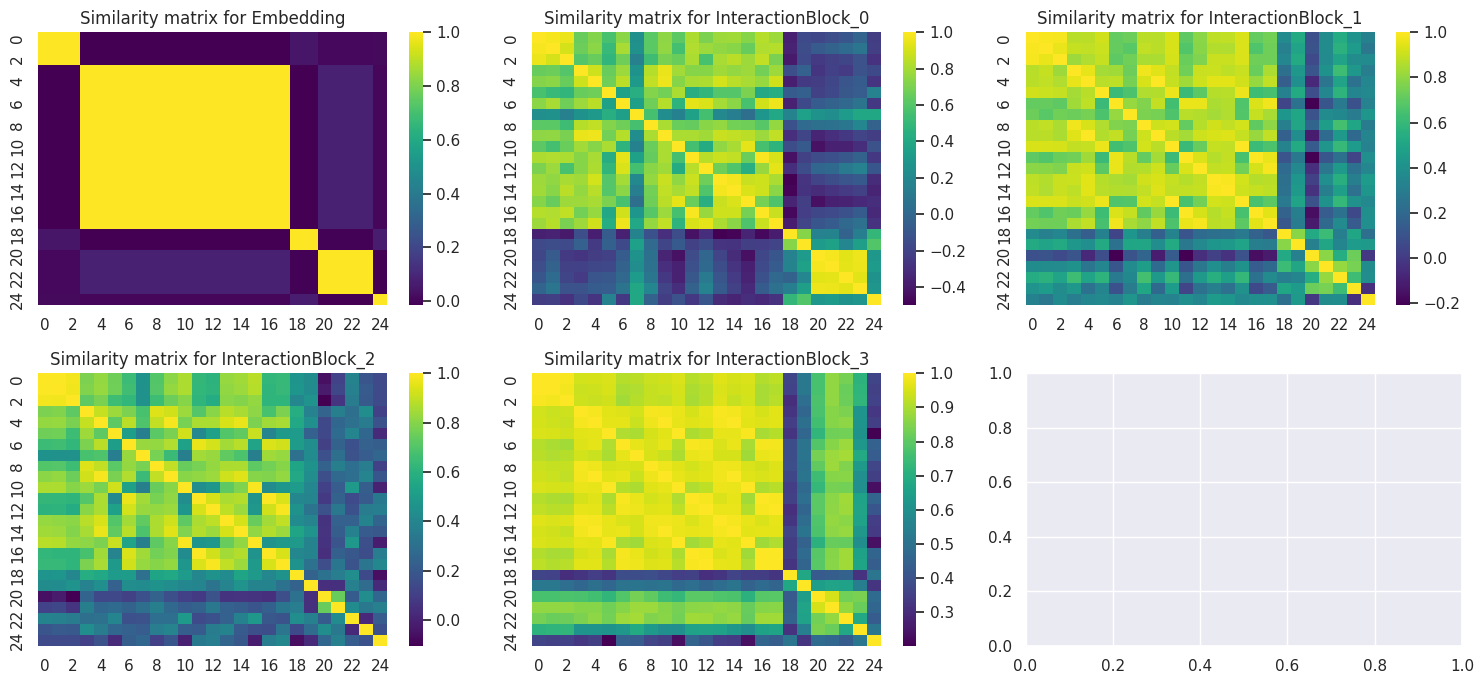

In [ ]:
plot_similarity_matrix(activations_dict_schnet, None)

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/a/ali.ramlaoui/ocp/runs/4119577/checkpoints/checkpoint-0043164.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_channel

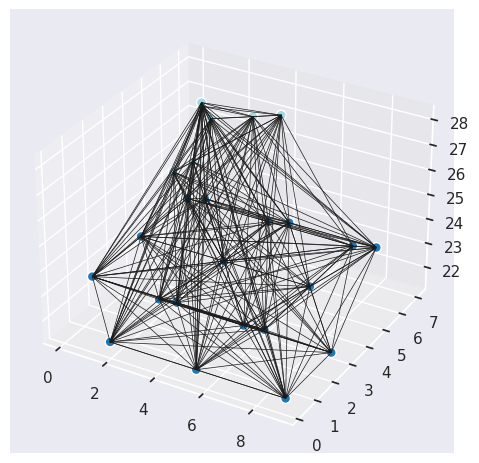

Graph with 25 nodes and 261 edges
{0: [0.0, 4.013790607452393, 22.82491683959961], 1: [3.596992254257202, 4.013790607452393, 22.82491683959961], 2: [7.193984508514404, 4.013790607452393, 22.82491683959961], 3: [0.0, 1.4703328609466553, 22.82491683959961], 4: [0.0, 6.557248115539551, 22.82491683959961], 5: [1.798496127128601, 0.19860410690307617, 21.55318832397461], 6: [1.798496127128601, 2.7420616149902344, 21.55318832397461], 7: [1.798496127128601, 5.285519123077393, 24.09664535522461], 8: [3.596992254257202, 1.4703328609466553, 22.82491683959961], 9: [3.596992254257202, 6.557248115539551, 22.82491683959961], 10: [5.395488262176514, 0.19860410690307617, 21.55318832397461], 11: [5.395488262176514, 2.7420616149902344, 21.55318832397461], 12: [5.395488262176514, 5.285519123077393, 24.09664535522461], 13: [7.193984508514404, 1.4703328609466553, 22.82491683959961], 14: [7.193984508514404, 6.557248115539551, 22.82491683959961], 15: [8.992480278015137, 0.19860410690307617, 21.55318832397461]

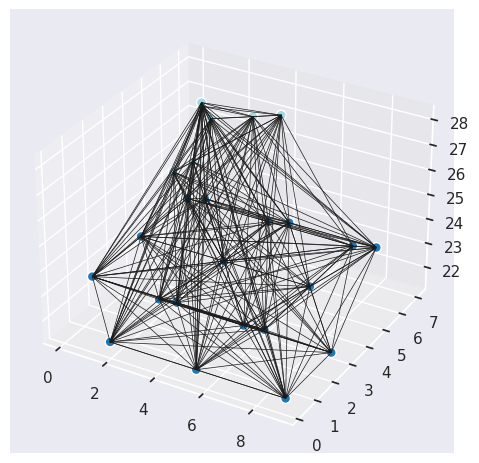

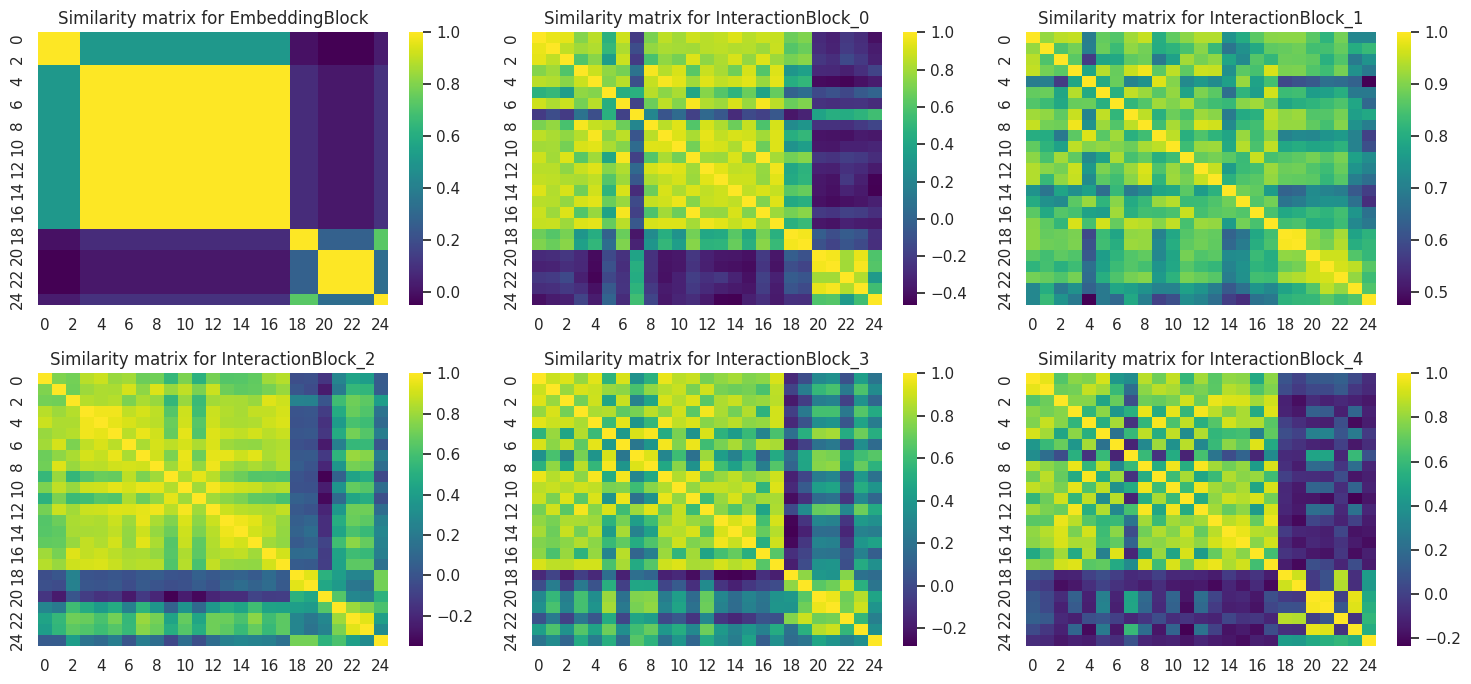

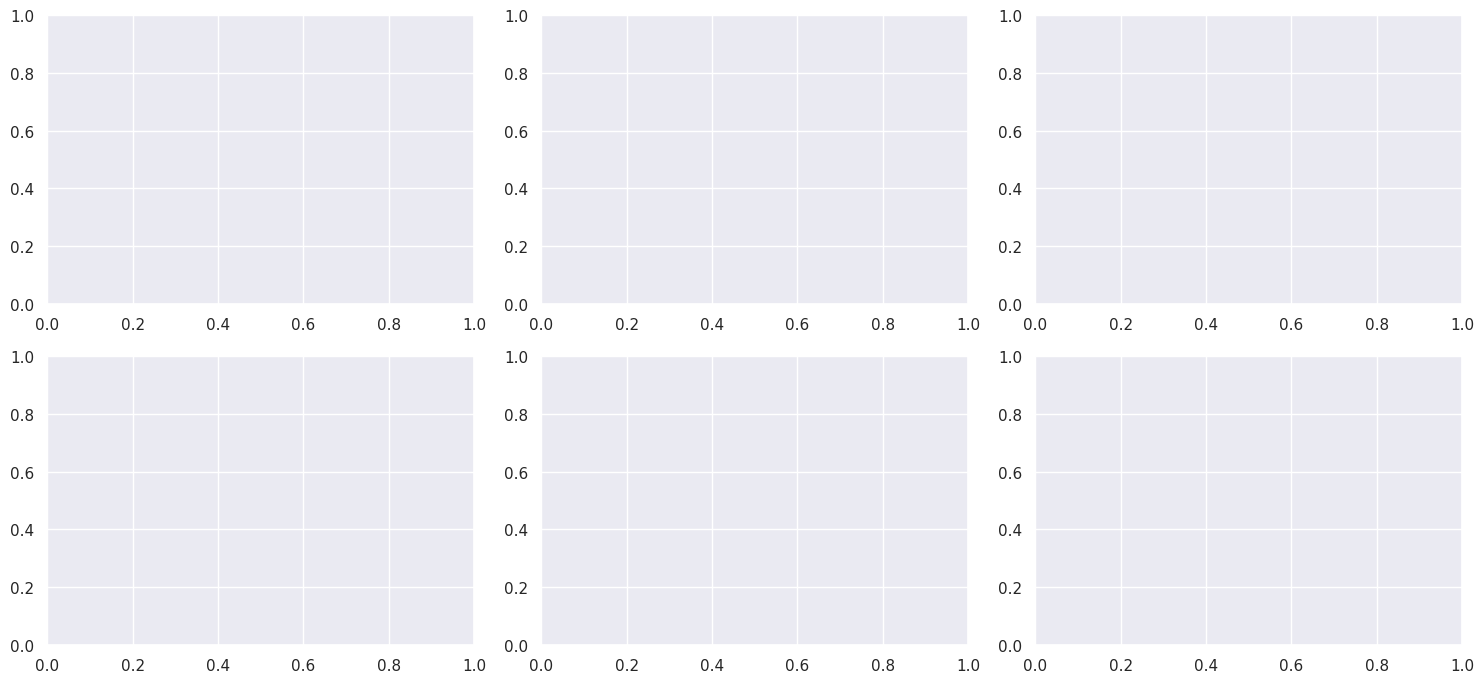

In [ ]:
job_id = "4119577" #faenet + ewald

trainer_schnet = load_checkpoint(job_id)
train_loader_schnet = trainer_schnet.get_dataloader(trainer_schnet.datasets["train"], trainer_schnet.samplers["train"])

activations_dict_schnet = {}

trainer_schnet.model.module.embed_block.register_forward_hook(get_activation(f"{trainer_schnet.model.module.embed_block.__class__.__name__}", activations_dict_schnet))

for i, block in enumerate(trainer_schnet.model.module.interaction_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict_schnet))

for i, block in enumerate(trainer_schnet.model.module.ewald_blocks):
    block.register_forward_hook(get_activation(f"{block.__class__.__name__}_{i}", activations_dict_schnet))


with torch.no_grad():
    for i, x in enumerate(train_loader_schnet):
        if i == 20:
            break
    # plot graph 
    data_graph = oc20_to_graph(x[0], processed=False)
    plot_element_3d(data_graph)
    x_processed = process_datapoint(x[0], trainer_schnet)
    data_graph = oc20_to_graph(x_processed)
    plot_element_3d(data_graph)
    base_output = trainer_schnet.model_forward(x)


In [ ]:
activations_dict_schnet

{'EmbeddingBlock': (tensor([[-0.1975, -0.2608, -0.2773,  ..., -0.0785, -0.2645,  2.5363],
          [-0.1975, -0.2608, -0.2773,  ..., -0.0785, -0.2645,  2.5363],
          [-0.1975, -0.2608, -0.2773,  ..., -0.0785, -0.2645,  2.5363],
          ...,
          [-0.2354, -0.0557, -0.2452,  ..., -0.0529, -0.2776, -0.1230],
          [-0.2354, -0.0557, -0.2452,  ..., -0.0529, -0.2776, -0.1230],
          [-0.1432, -0.0830, -0.2633,  ..., -0.1962, -0.2666, -0.0888]],
         device='cuda:0'),
  tensor([[ 0.3147,  0.0401, -0.0697,  ...,  0.0107, -0.0985, -0.0400],
          [ 0.1147,  0.0580, -0.2065,  ...,  0.0107, -0.0985, -0.0400],
          [ 0.1886,  0.0161, -0.0951,  ...,  0.0107, -0.0985, -0.0400],
          ...,
          [-0.2566, -0.0852,  0.1127,  ...,  0.0417,  0.2327, -0.0068],
          [-0.2105, -0.0662, -0.0175,  ...,  0.0476,  0.2770,  0.0207],
          [-0.0724, -0.1386,  1.1310,  ...,  0.0135,  0.4812, -0.0601]],
         device='cuda:0')),
 'EwaldBlock_0': (tensor([[-0.2

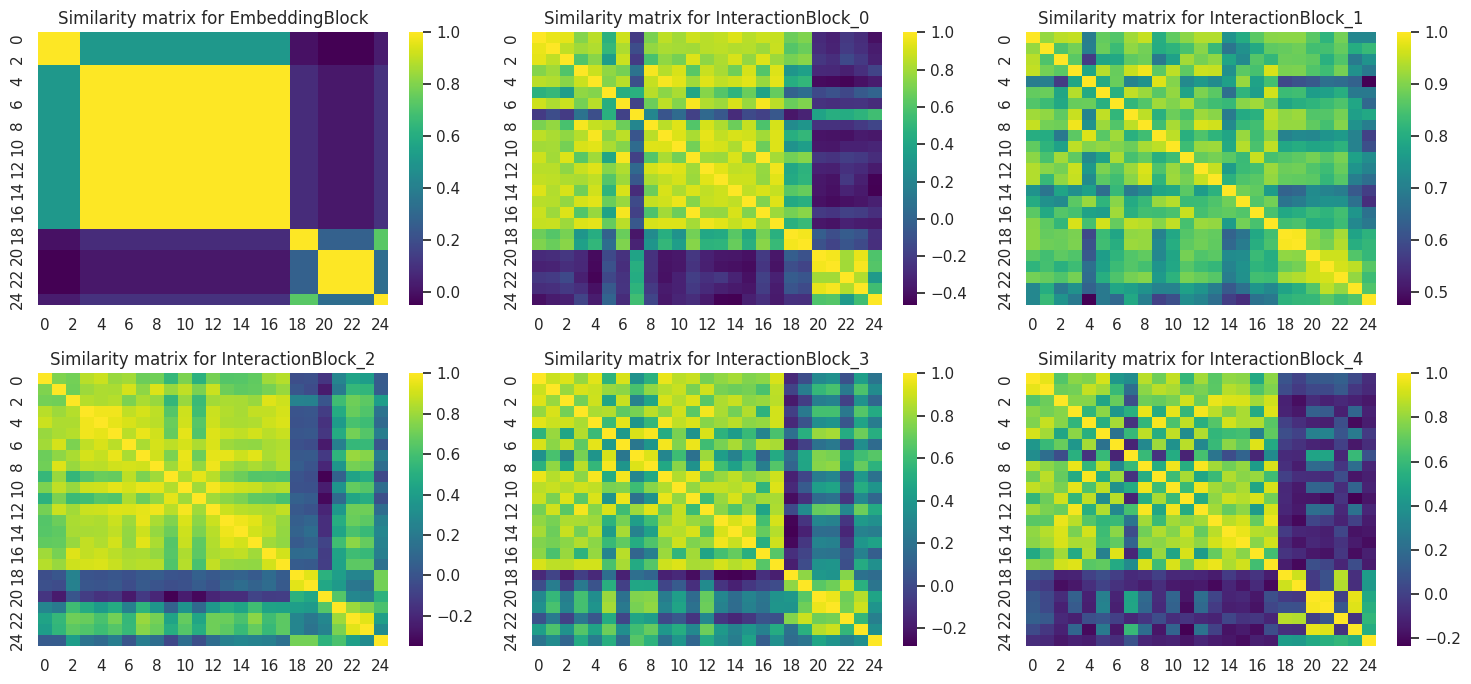

In [ ]:
plot_similarity_matrix(activations_dict_schnet, None, type_="base")

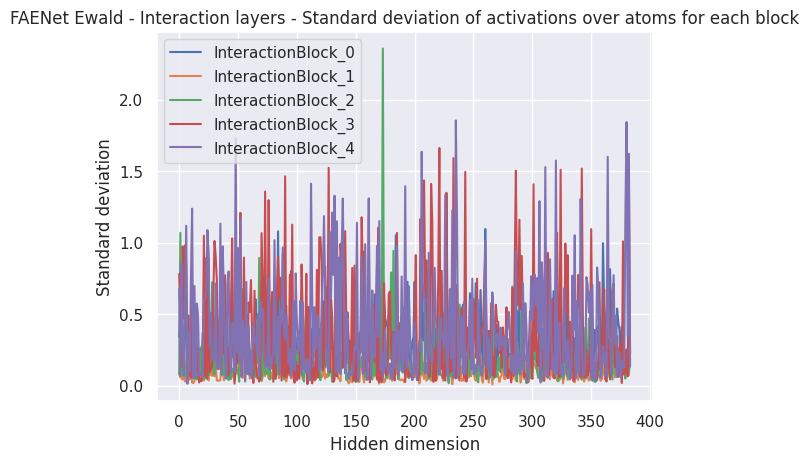

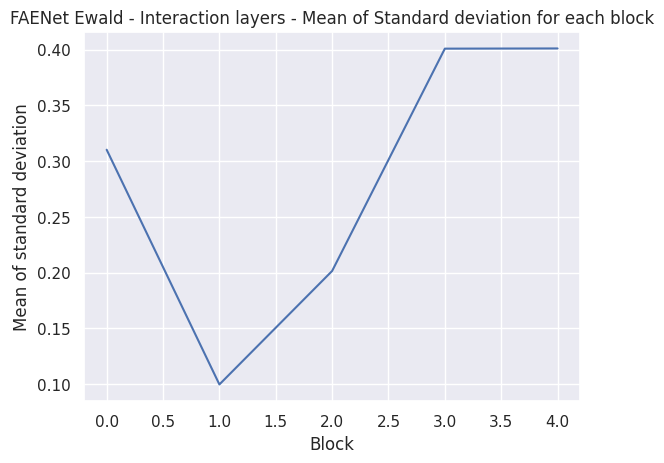

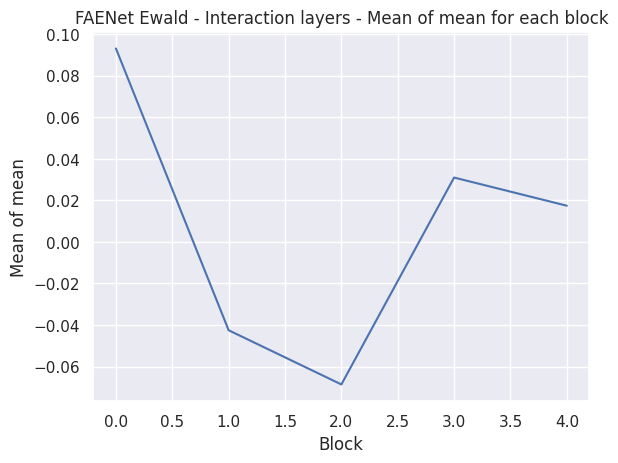

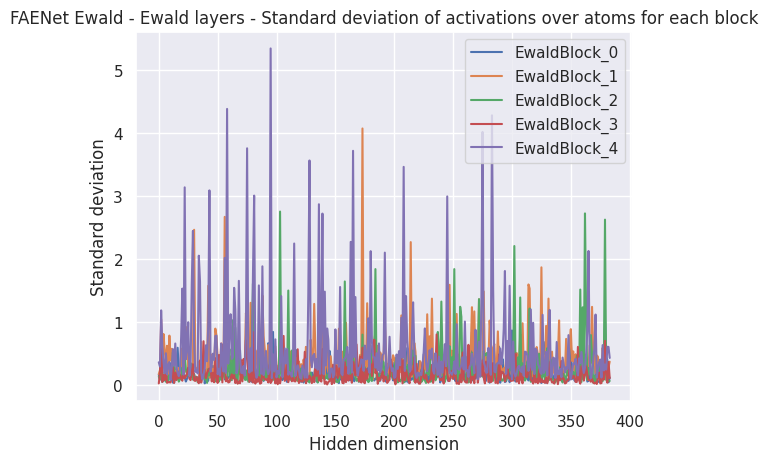

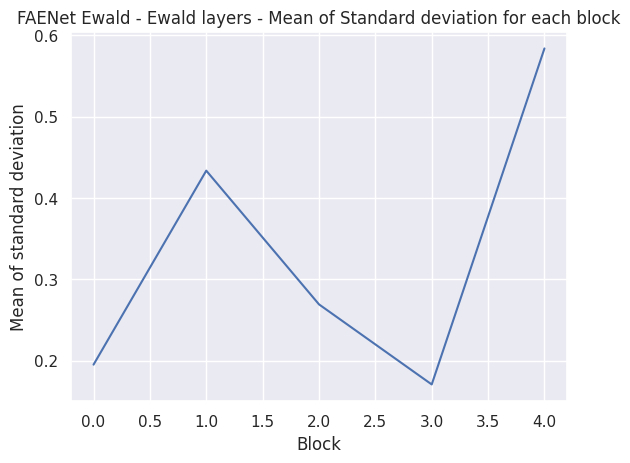

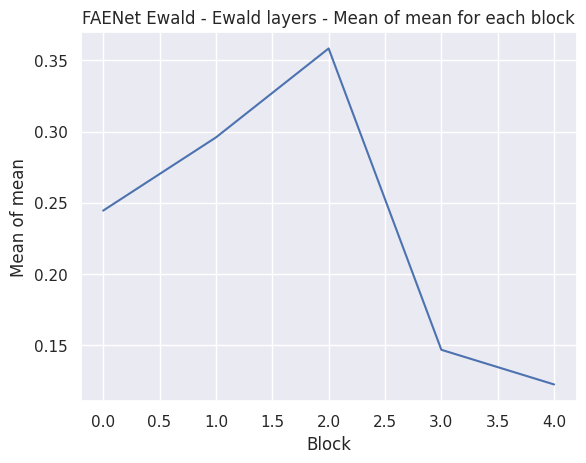

In [ ]:
plot_std_interactions(trainer_schnet, activations_dict_schnet, title="FAENet Ewald - Interaction layers", type_="base")
plot_std_interactions(trainer_schnet, activations_dict_schnet, title="FAENet Ewald - Ewald layers", type_="ewald")

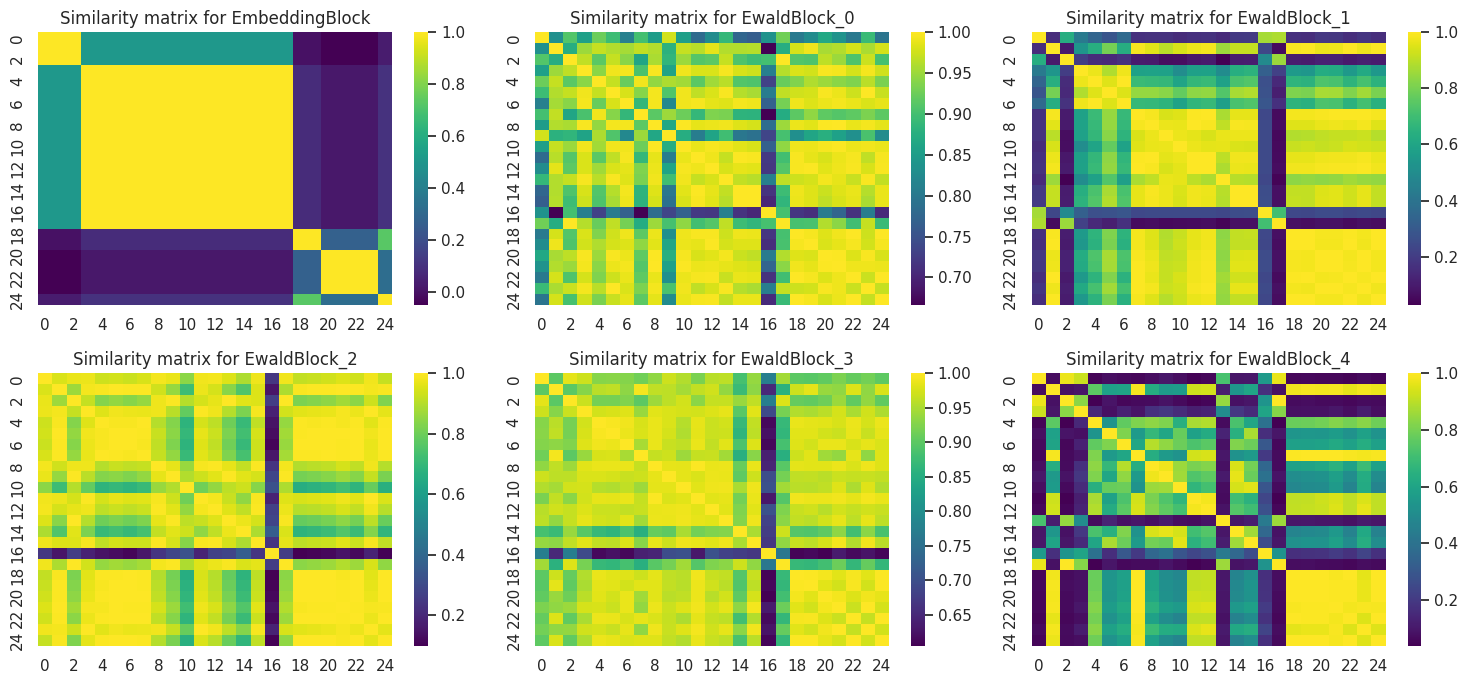

In [ ]:
plot_similarity_matrix(activations_dict_schnet, None, type_="ewald")

## Noisy Nodes

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/b/basile.terver/ocp/runs/4642620/checkpoints/checkpoint-0016191.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'se3-random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 352, 'num_filters': 288, 'num_interactions': 5, 'num_gaussians': 68, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 4.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 32, 'pg_hidden_channels': 96, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'updownscale_base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': 

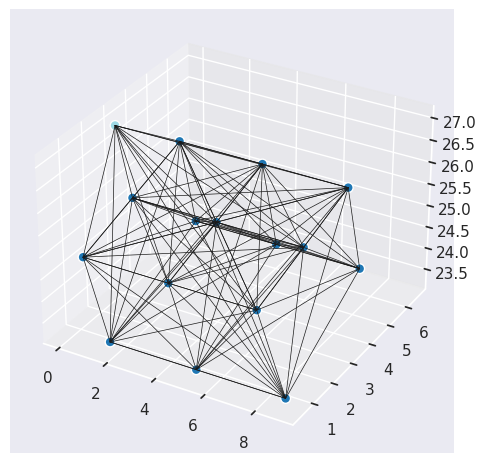

Graph with 16 nodes and 102 edges
{0: [1.7751826047897339, 0.4340120851993561, 23.29562759399414], 1: [0.0, 6.5839338302612305, 23.29738998413086], 2: [0.0, 3.5089728832244873, 25.072132110595703], 3: [5.325547695159912, 0.4340120851993561, 23.29562759399414], 4: [3.5503649711608887, 6.5839338302612305, 23.29738998413086], 5: [3.5503649711608887, 3.5089728832244873, 25.072132110595703], 6: [8.8759126663208, 0.4340120851993561, 23.29562759399414], 7: [7.100729942321777, 6.5839338302612305, 23.29738998413086], 8: [7.100729942321777, 3.5089728832244873, 25.072132110595703], 9: [0.0, 5.8151936531066895, 25.516698837280273], 10: [0.0, 1.2027522325515747, 24.627565383911133], 11: [3.5503649711608887, 5.8151936531066895, 25.516698837280273], 12: [3.5503649711608887, 1.2027522325515747, 24.627565383911133], 13: [7.100729942321777, 5.8151936531066895, 25.516698837280273], 14: [7.100729942321777, 1.2027522325515747, 24.627565383911133], 15: [0.03854503482580185, 2.765753746032715, 27.00372314453

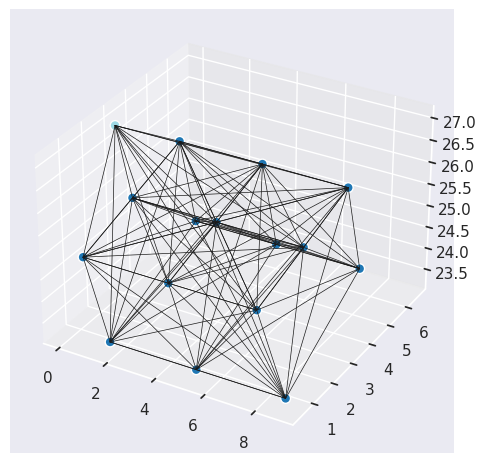

In [37]:
trainer_faenet_top, train_loader_faenet_top, activations_dict_faenet_top, _ = setup_and_plot_graph('4642620', 21)

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/b/basile.terver/ocp/runs/4648465/checkpoints/checkpoint-0359650.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'se3-random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 5, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_ch

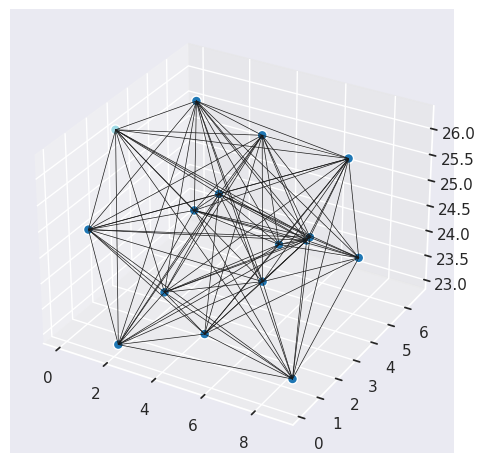

Graph with 16 nodes and 102 edges
{0: [2.1188628673553467, 0.08363518118858337, 23.048002243041992], 1: [0.0, 6.5839338302612305, 23.29738998413086], 2: [7.402952194213867, 3.2931418418884277, 24.827455520629883], 3: [5.287087917327881, 0.5668172836303711, 23.56841278076172], 4: [3.6657772064208984, 6.659657955169678, 23.063552856445312], 5: [3.5503649711608887, 3.5089728832244873, 25.072132110595703], 6: [8.8759126663208, 0.4340120851993561, 23.29562759399414], 7: [7.100729942321777, 6.5839338302612305, 23.29738998413086], 8: [7.097115993499756, 3.5346109867095947, 24.643863677978516], 9: [0.9794172048568726, 5.556143283843994, 25.943218231201172], 10: [0.0, 1.2027522325515747, 24.627565383911133], 11: [3.5503649711608887, 5.8151936531066895, 25.516698837280273], 12: [3.190446138381958, 1.1383708715438843, 23.87413215637207], 13: [7.100729942321777, 5.8151936531066895, 25.516698837280273], 14: [7.100729942321777, 1.2027522325515747, 24.627565383911133], 15: [0.22768504917621613, 2.379

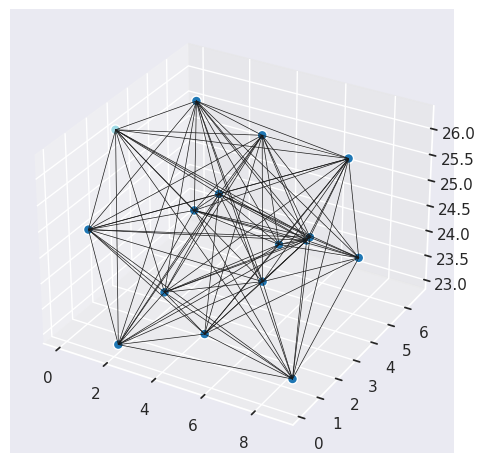

In [38]:
trainer_faenet_aux_5i, train_loader_faenet_aux_5i, activations_dict_faenet_aux_5i, _ = setup_and_plot_graph('4648465', 21)

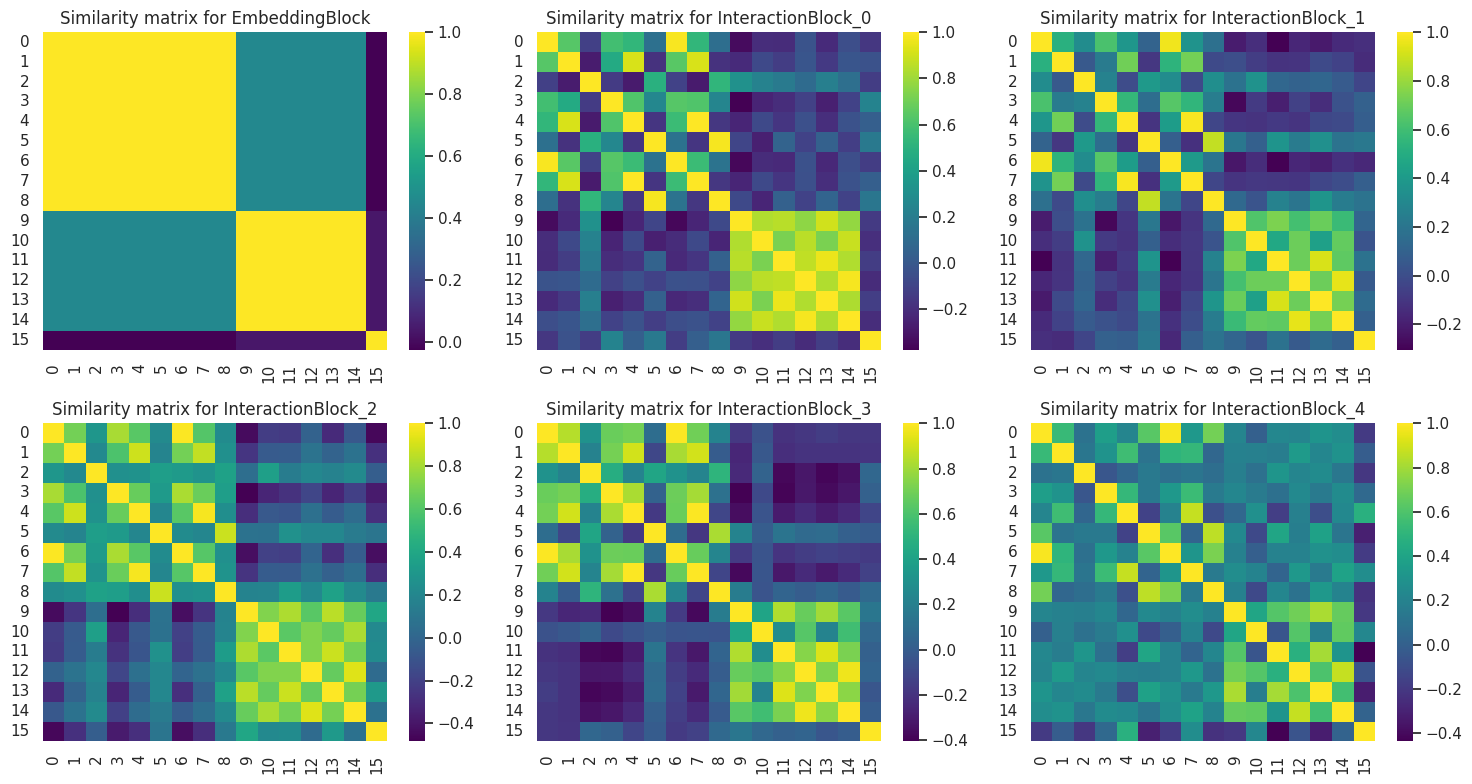

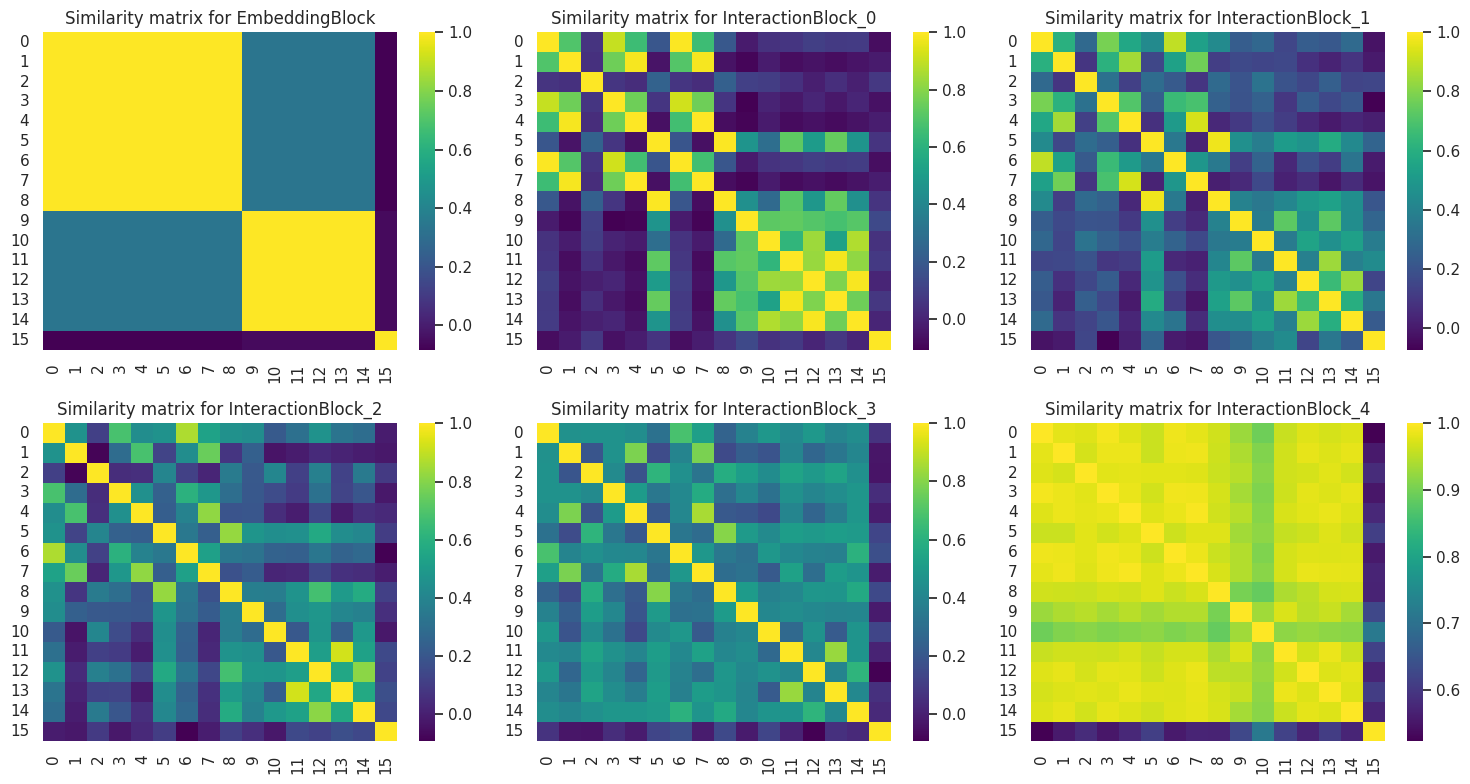

In [39]:
plot_similarity_matrix(activations_dict_faenet_top, None, type_="base")
plot_similarity_matrix(activations_dict_faenet_aux_5i, None, type_="base")

In the above plots, whatever the graph_idx we choose to plot the activations' similarities for, we get a collapse of the embeddings at the last layer for the IS2RE with auxiliary IS2RS task model: all the embedding become very similar.

(5, 1000)


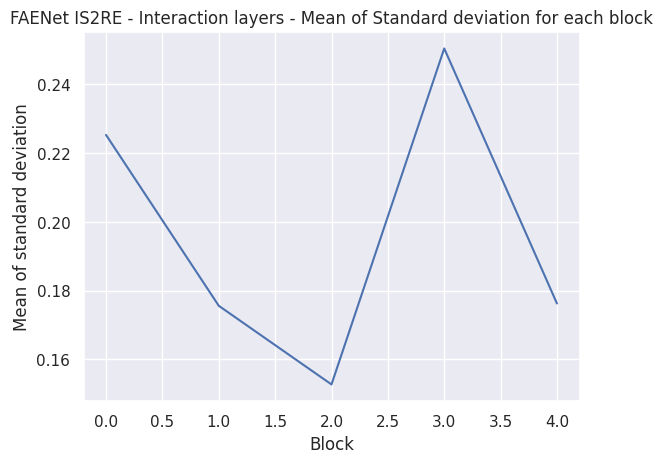

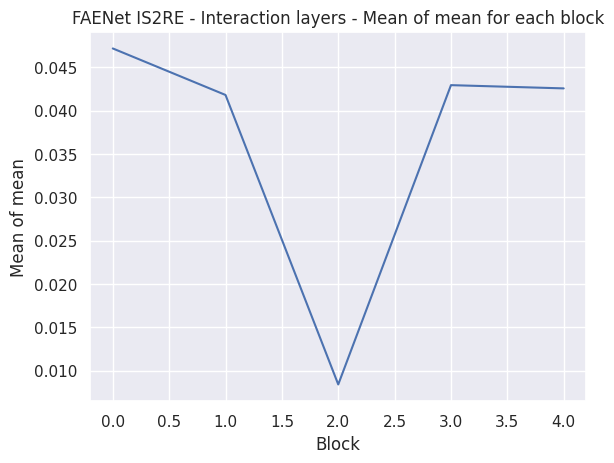

(5, 1000)


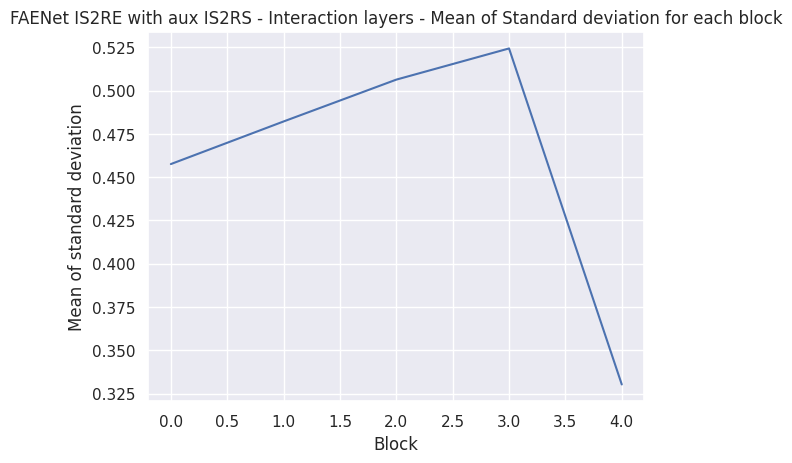

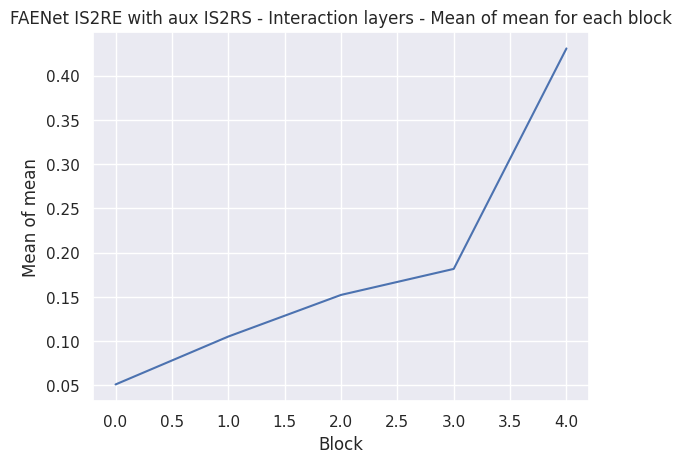

In [40]:
plot_std_interactions(trainer_faenet_top, activations_dict_faenet_top, title="FAENet IS2RE - Interaction layers", type_="base")
plot_std_interactions(trainer_faenet_aux_5i, activations_dict_faenet_aux_5i, title="FAENet IS2RE with aux IS2RS - Interaction layers", type_="base")

### Mean Average Distance (MAD)

The MAD is computed for a single graph throughout the interaction layers. We plot the average of the MADs for a number of graphs.

collecting data: 1000it [00:28, 34.58it/s]


blocks ['InteractionBlock_0', 'InteractionBlock_1', 'InteractionBlock_2', 'InteractionBlock_3', 'InteractionBlock_4']
mad_values [0.87462777, 0.85378796, 0.8086909, 0.86433446, 0.74803793]


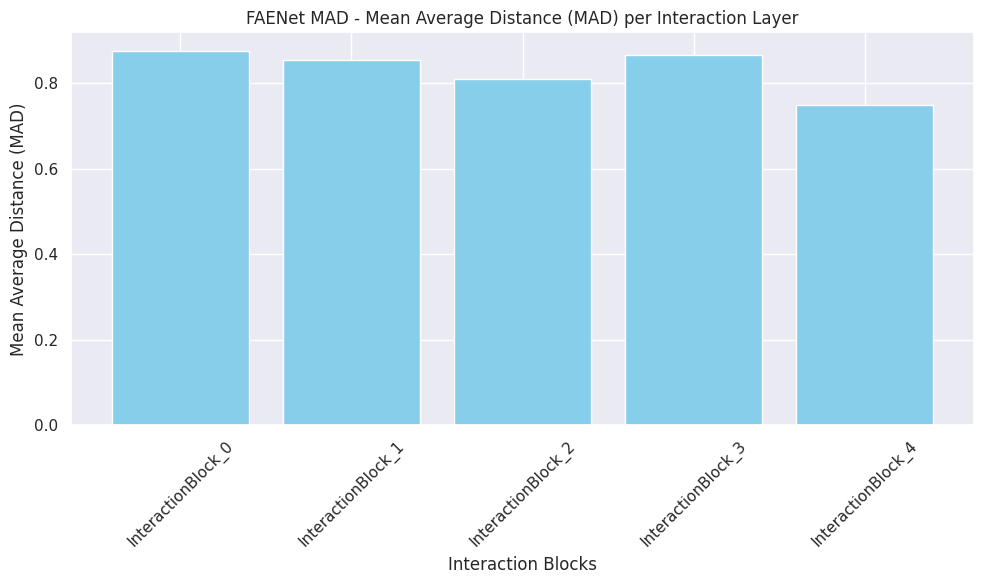

collecting data: 1000it [00:30, 33.31it/s]


blocks ['InteractionBlock_0', 'InteractionBlock_1', 'InteractionBlock_2', 'InteractionBlock_3', 'InteractionBlock_4']
mad_values [0.8169827, 0.8045399, 0.77532434, 0.7270148, 0.12677433]


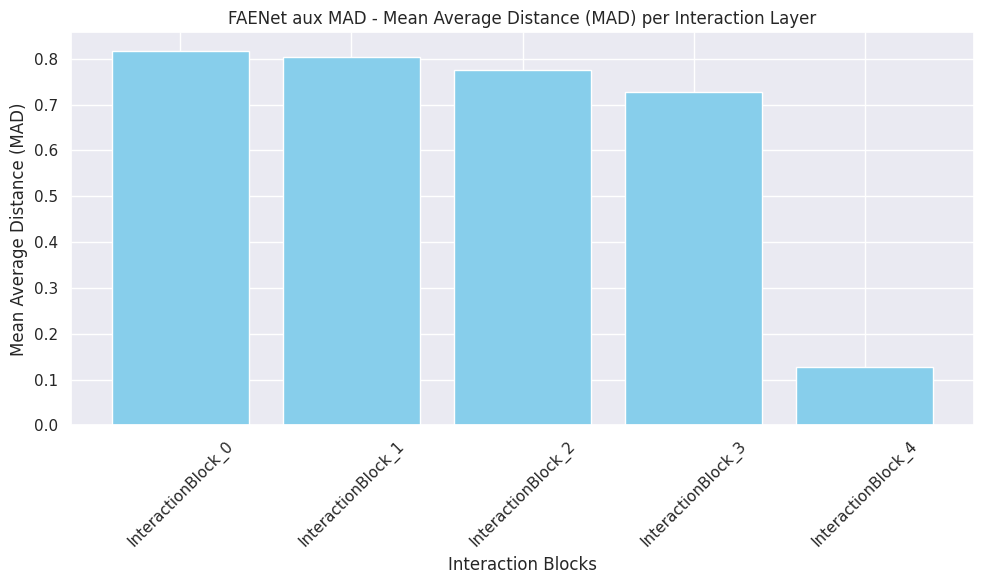

In [41]:
plot_mad_interactions(trainer_faenet_top, activations_dict_faenet_top, nb_batches=1000, title="FAENet MAD", type_="base")
plot_mad_interactions(trainer_faenet_aux_5i, activations_dict_faenet_aux_5i,nb_batches=1000, title="FAENet aux MAD", type_="base")

### FAENet_aux with more interaction blocks.

In [65]:
graph_idx=23
num_batches_MAD = 100

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/b/basile.terver/ocp/runs/4648466/checkpoints/checkpoint-0359650.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'se3-random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 8, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_ch

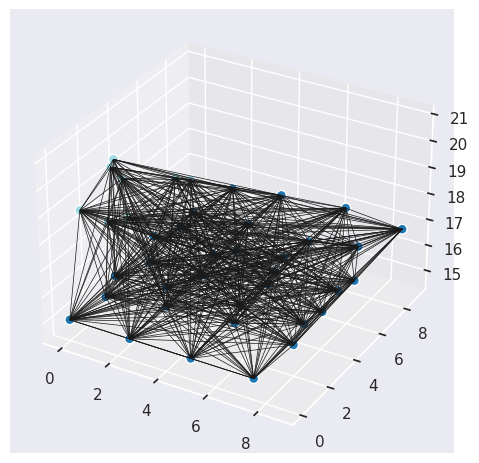

Graph with 40 nodes and 622 edges
{0: [-0.08424846082925797, 2.500432252883911, 14.704221725463867], 1: [1.1450855731964111, 1.2729984521865845, 16.46959114074707], 2: [0.492522269487381, 4.6959452629089355, 15.187142372131348], 3: [1.2535738945007324, 3.7607216835021973, 16.841800689697266], 4: [-0.06429136544466019, 7.7971296310424805, 15.02811050415039], 5: [1.4076893329620361, 6.291696071624756, 16.683500289916992], 6: [0.0, 0.0, 15.06898021697998], 7: [1.5523697137832642, 8.973048210144043, 16.443359375], 8: [2.507147789001465, 2.507147789001465, 15.06898021697998], 9: [3.330980062484741, 1.202364206314087, 16.67095947265625], 10: [2.507147789001465, 5.01429557800293, 15.06898021697998], 11: [3.7607216835021973, 3.7607216835021973, 16.841800689697266], 12: [2.607288122177124, 7.407859802246094, 14.957530975341797], 13: [3.7607216835021973, 6.267869472503662, 16.841800689697266], 14: [2.507147789001465, 0.0, 15.06898021697998], 15: [3.7607216835021973, 8.775016784667969, 16.8418006

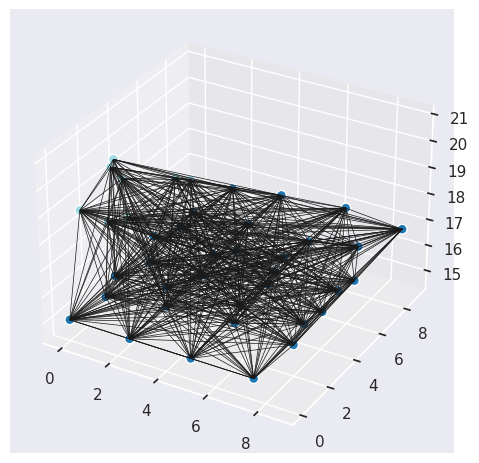

🅾️  Removing orion config from continue config. Set to None: {}
✅ Loading config from /network/scratch/b/basile.terver/ocp/runs/4648467/checkpoints/checkpoint-0359650.pt (and loading latest checkpoint)
🏭 Overriding num_workers from 4 to 1 to match the machine's CPUs. Use --no_cpus_to_workers=true to disable this behavior.
{'frame_averaging': '2D', 'fa_method': 'se3-random', 'model': {'name': 'faenet', 'act': 'swish', 'hidden_channels': 384, 'num_filters': 480, 'num_interactions': 10, 'num_gaussians': 104, 'dropout_lin': 0.0, 'dropout_edge': 0.0, 'dropout_lowest_layer': 'output', 'first_trainable_layer': '', 'cutoff': 6.0, 'use_pbc': True, 'regress_forces': '', 'tag_hidden_channels': 64, 'pg_hidden_channels': 64, 'phys_embeds': True, 'phys_hidden_channels': 0, 'energy_head': 'weighted-av-final-embeds', 'skip_co': 'concat', 'second_layer_MLP': False, 'complex_mp': True, 'mp_type': 'base', 'graph_norm': True, 'force_decoder_type': 'mlp', 'force_decoder_model_config': {'simple': {'hidden_c

In [66]:
trainer_faenet_aux_8i, train_loader_faenet_aux_8i, activations_dict_faenet_aux_8i, output_faenet_aux_8i = setup_and_plot_graph('4648466', graph_idx)
trainer_faenet_aux_10i, train_loader_faenet_aux_10i, activations_dict_faenet_aux_10i, output_faenet_aux_10i = setup_and_plot_graph('4648467', graph_idx, plot=False)
trainer_faenet_aux_12i, train_loader_faenet_aux_12i, activations_dict_faenet_aux_12i, output_faenet_aux_12i = setup_and_plot_graph('4648468', graph_idx, plot=False)
trainer_faenet_aux_14i, train_loader_faenet_aux_14i, activations_dict_faenet_aux_14i, output_faenet_aux_14i = setup_and_plot_graph('4648469', graph_idx, plot=False)
trainer_faenet_aux_16i, train_loader_faenet_aux_16i, activations_dict_faenet_aux_16i, output_faenet_aux_16i = setup_and_plot_graph('4648470', graph_idx, plot=False)

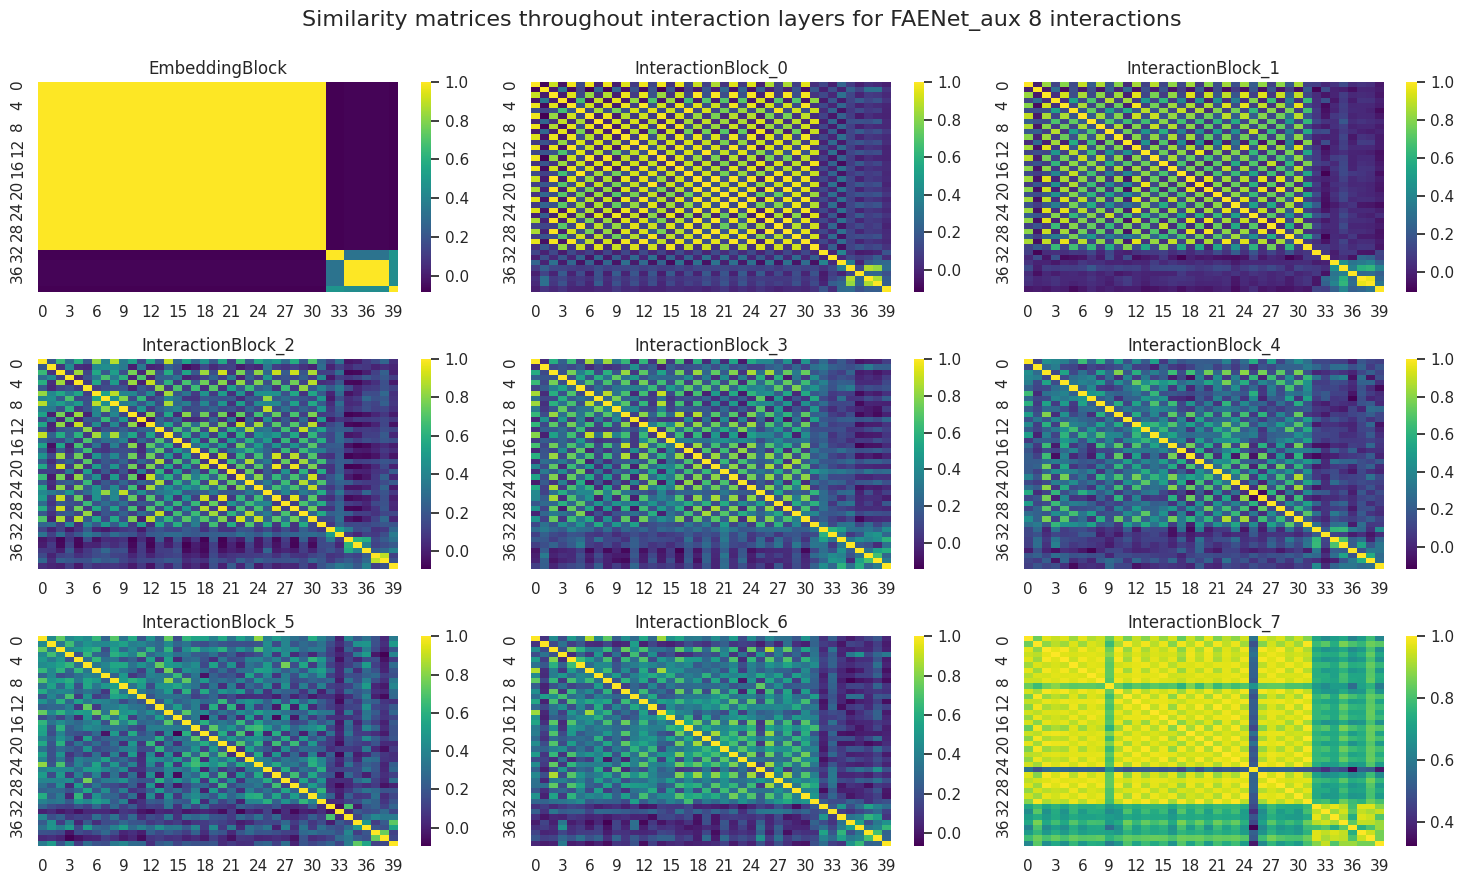

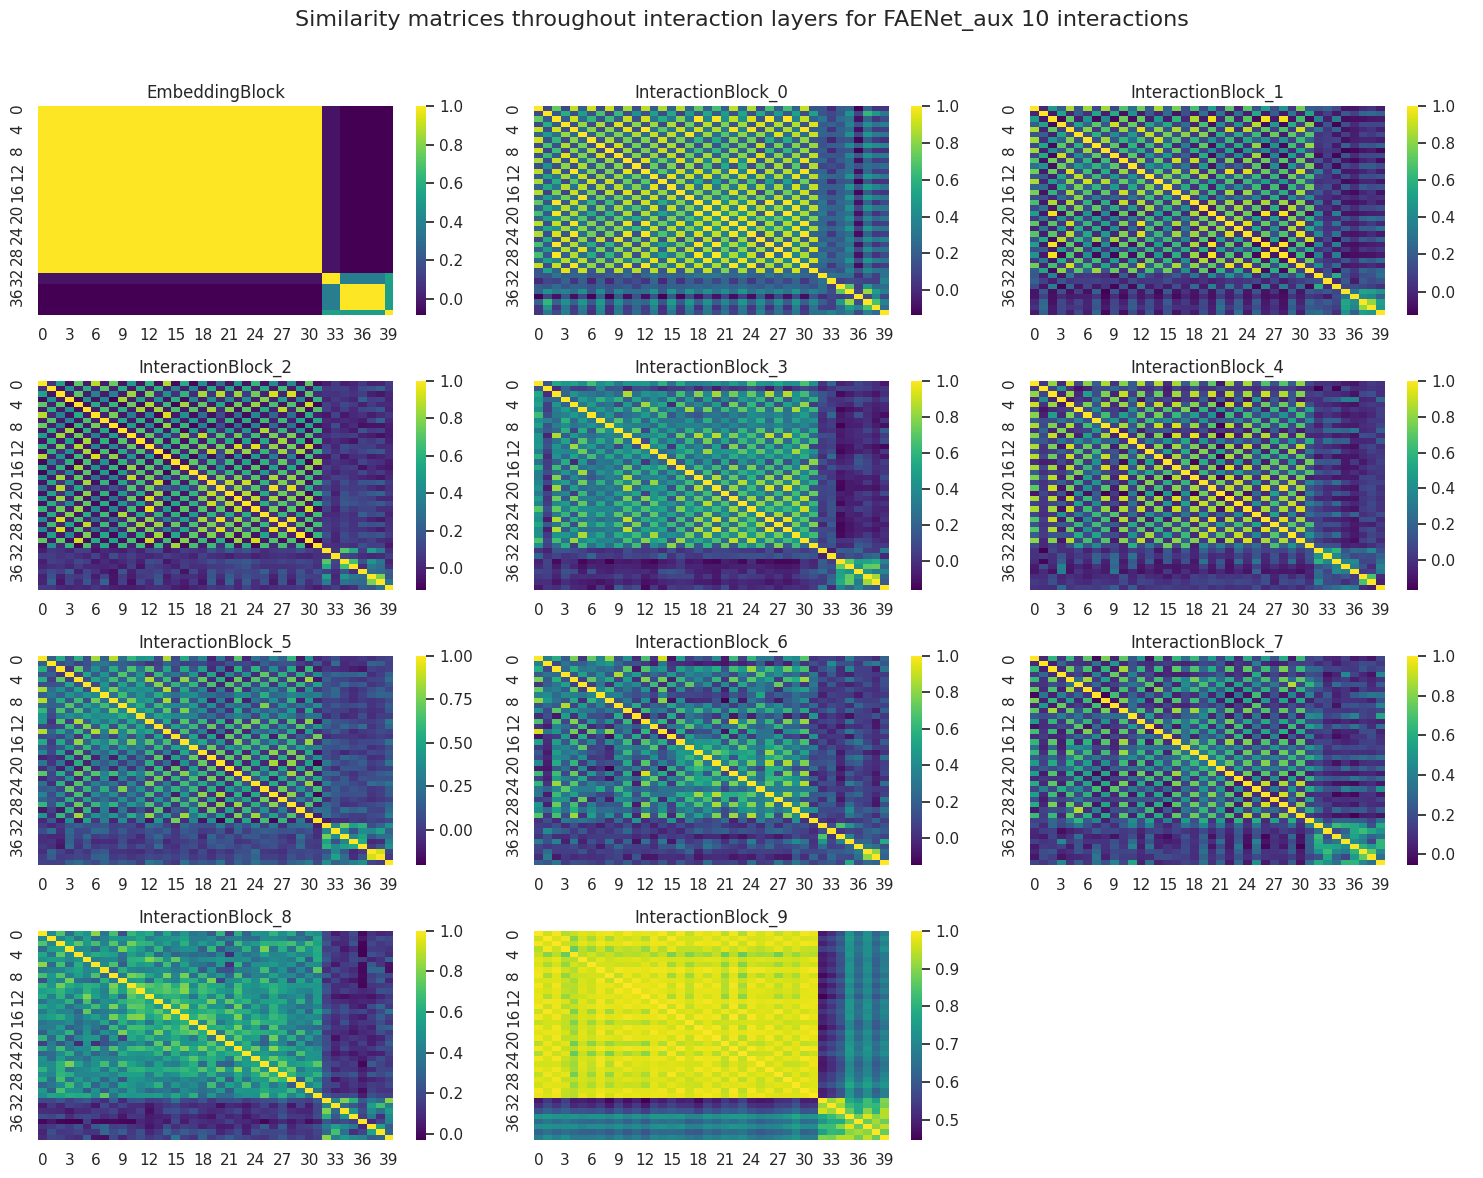

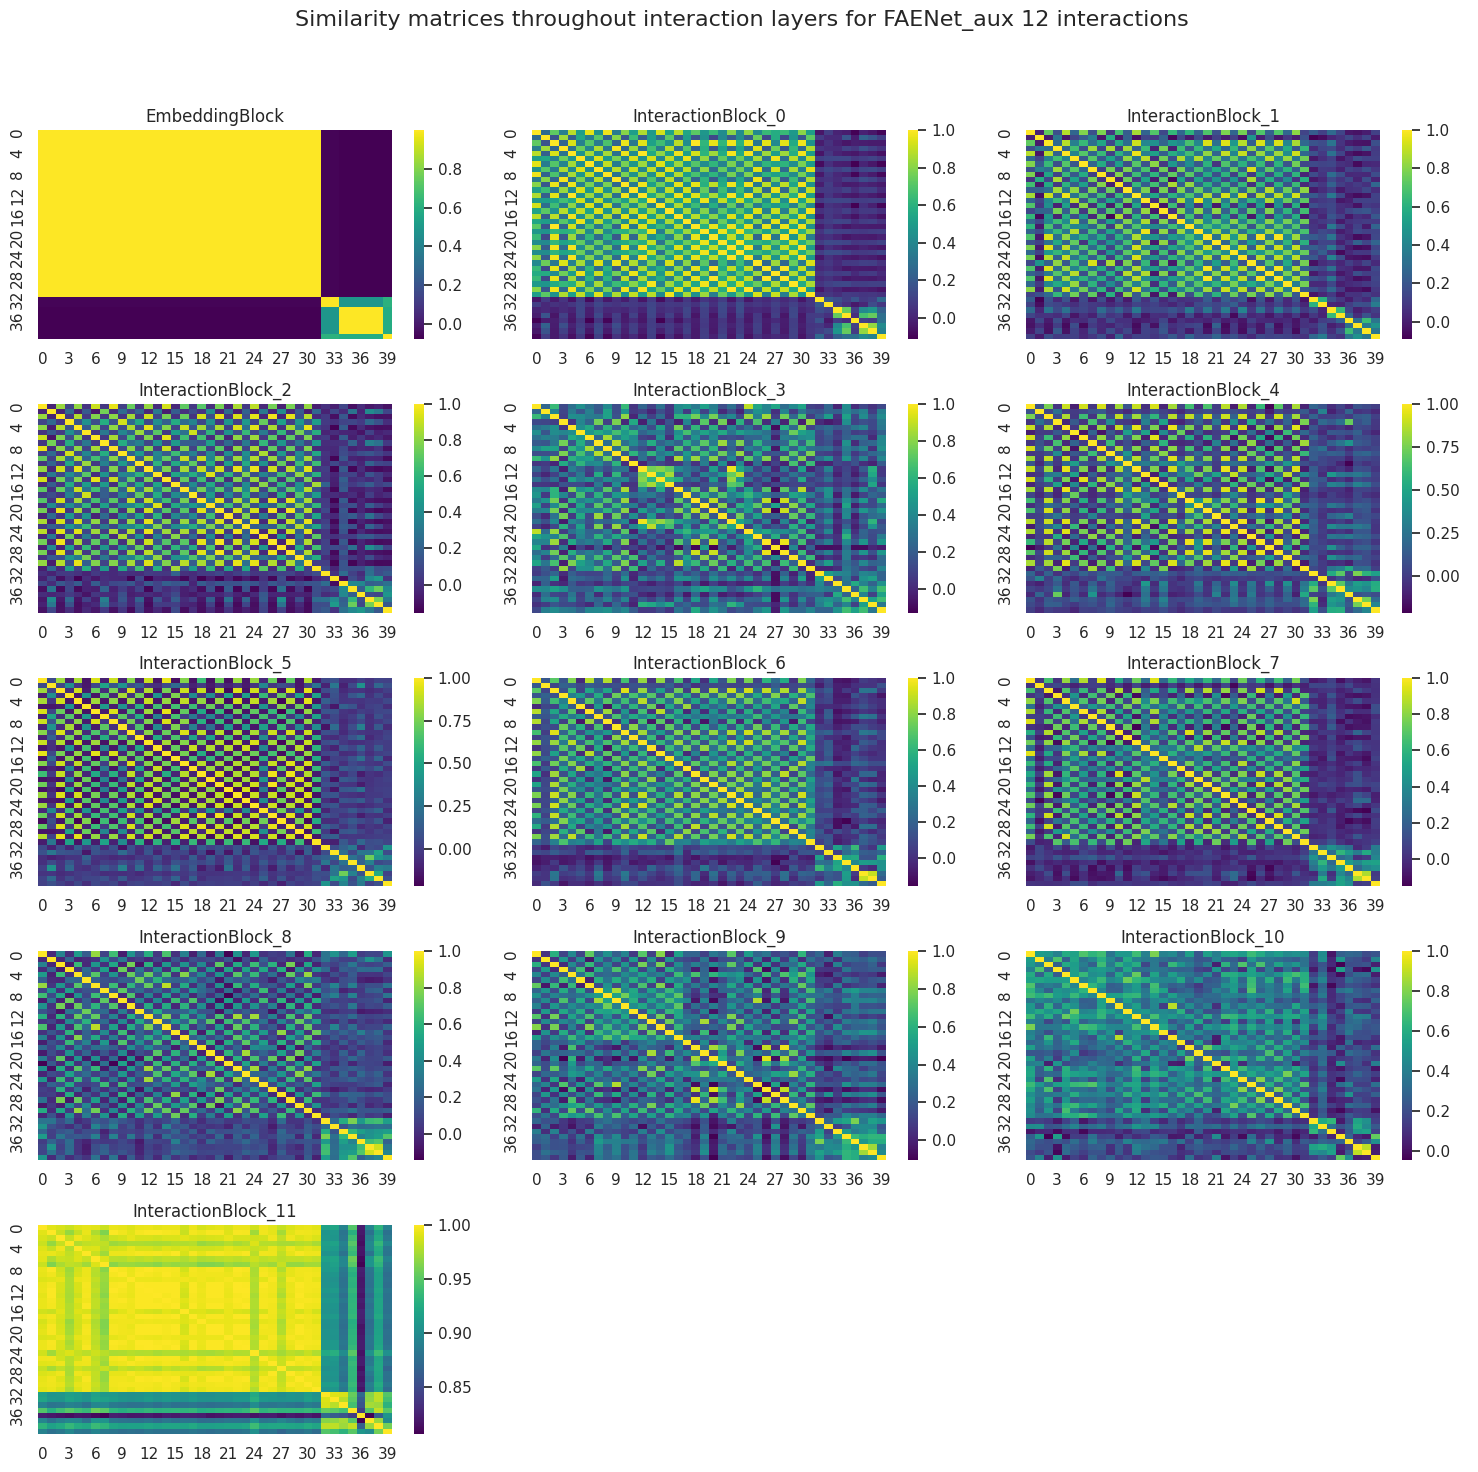

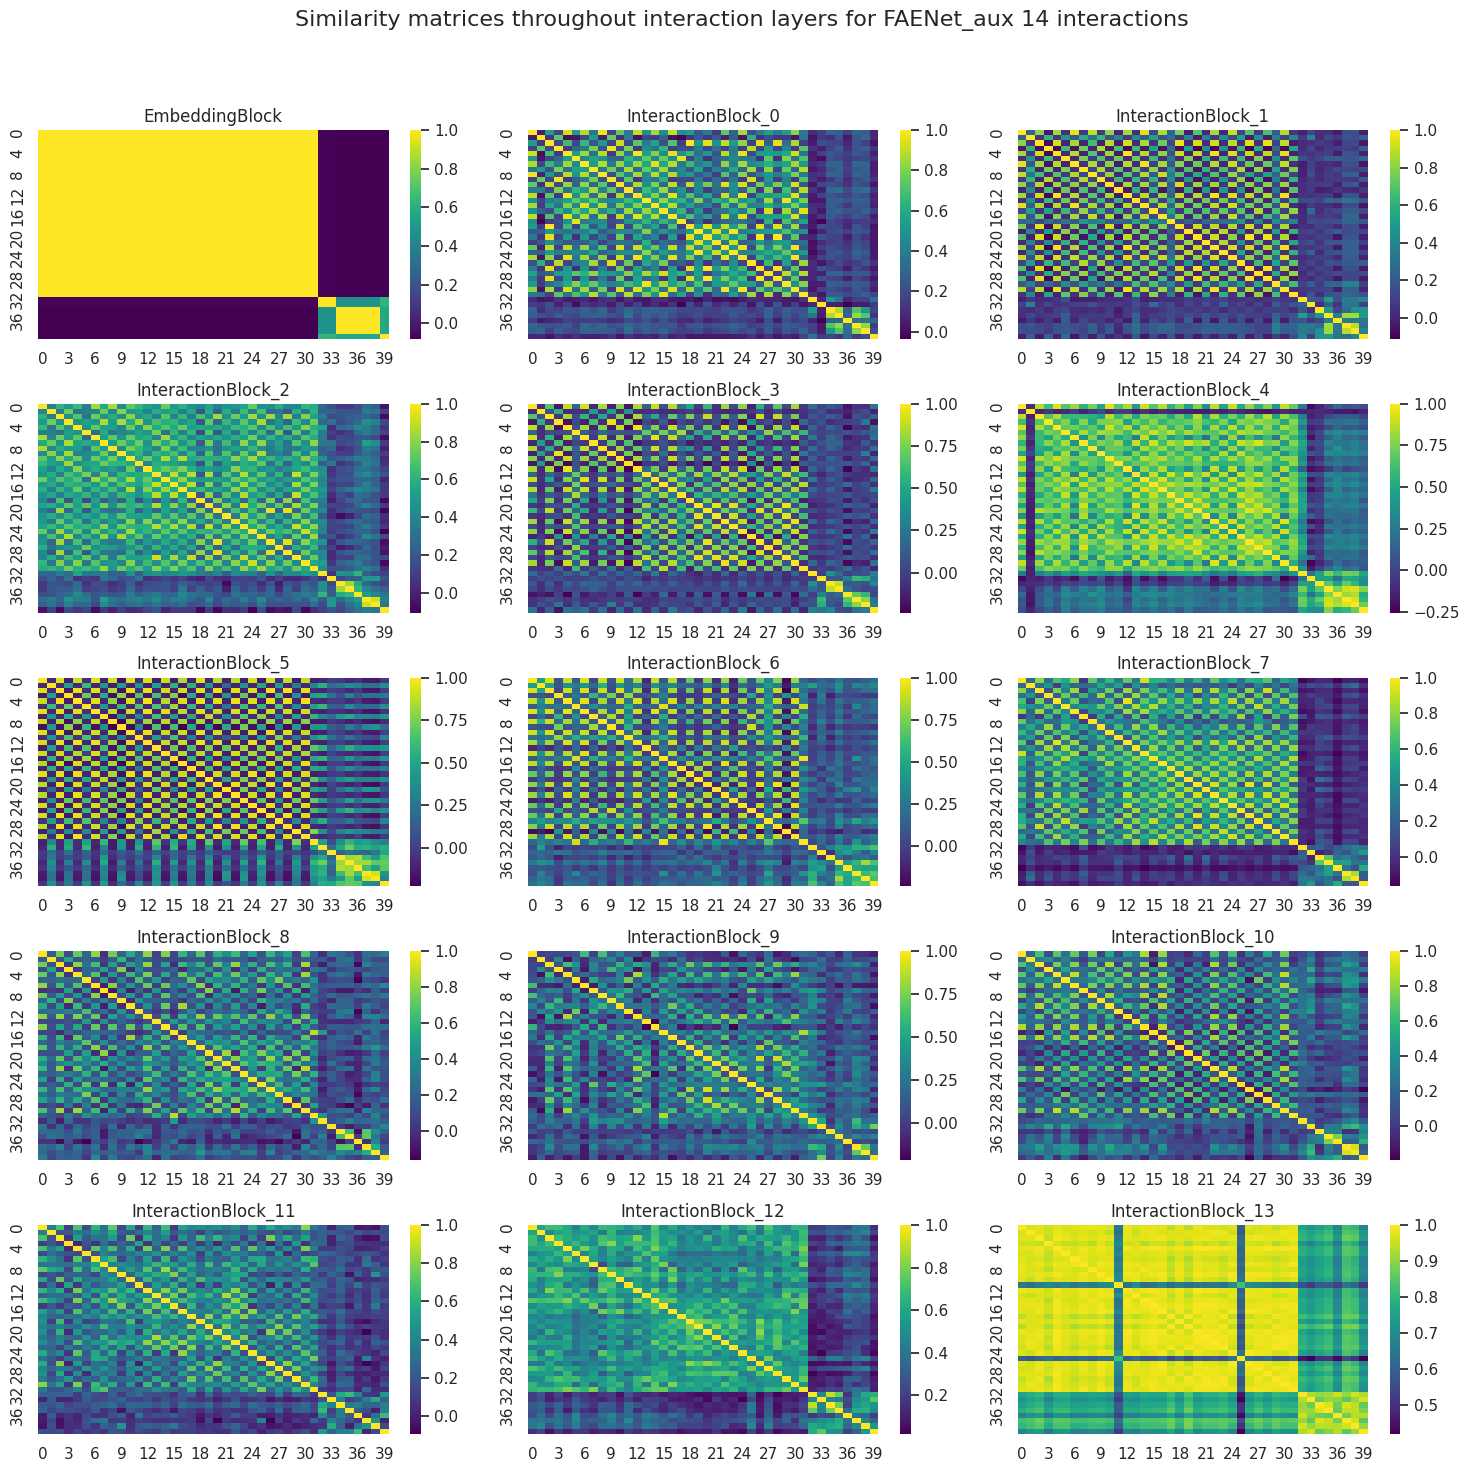

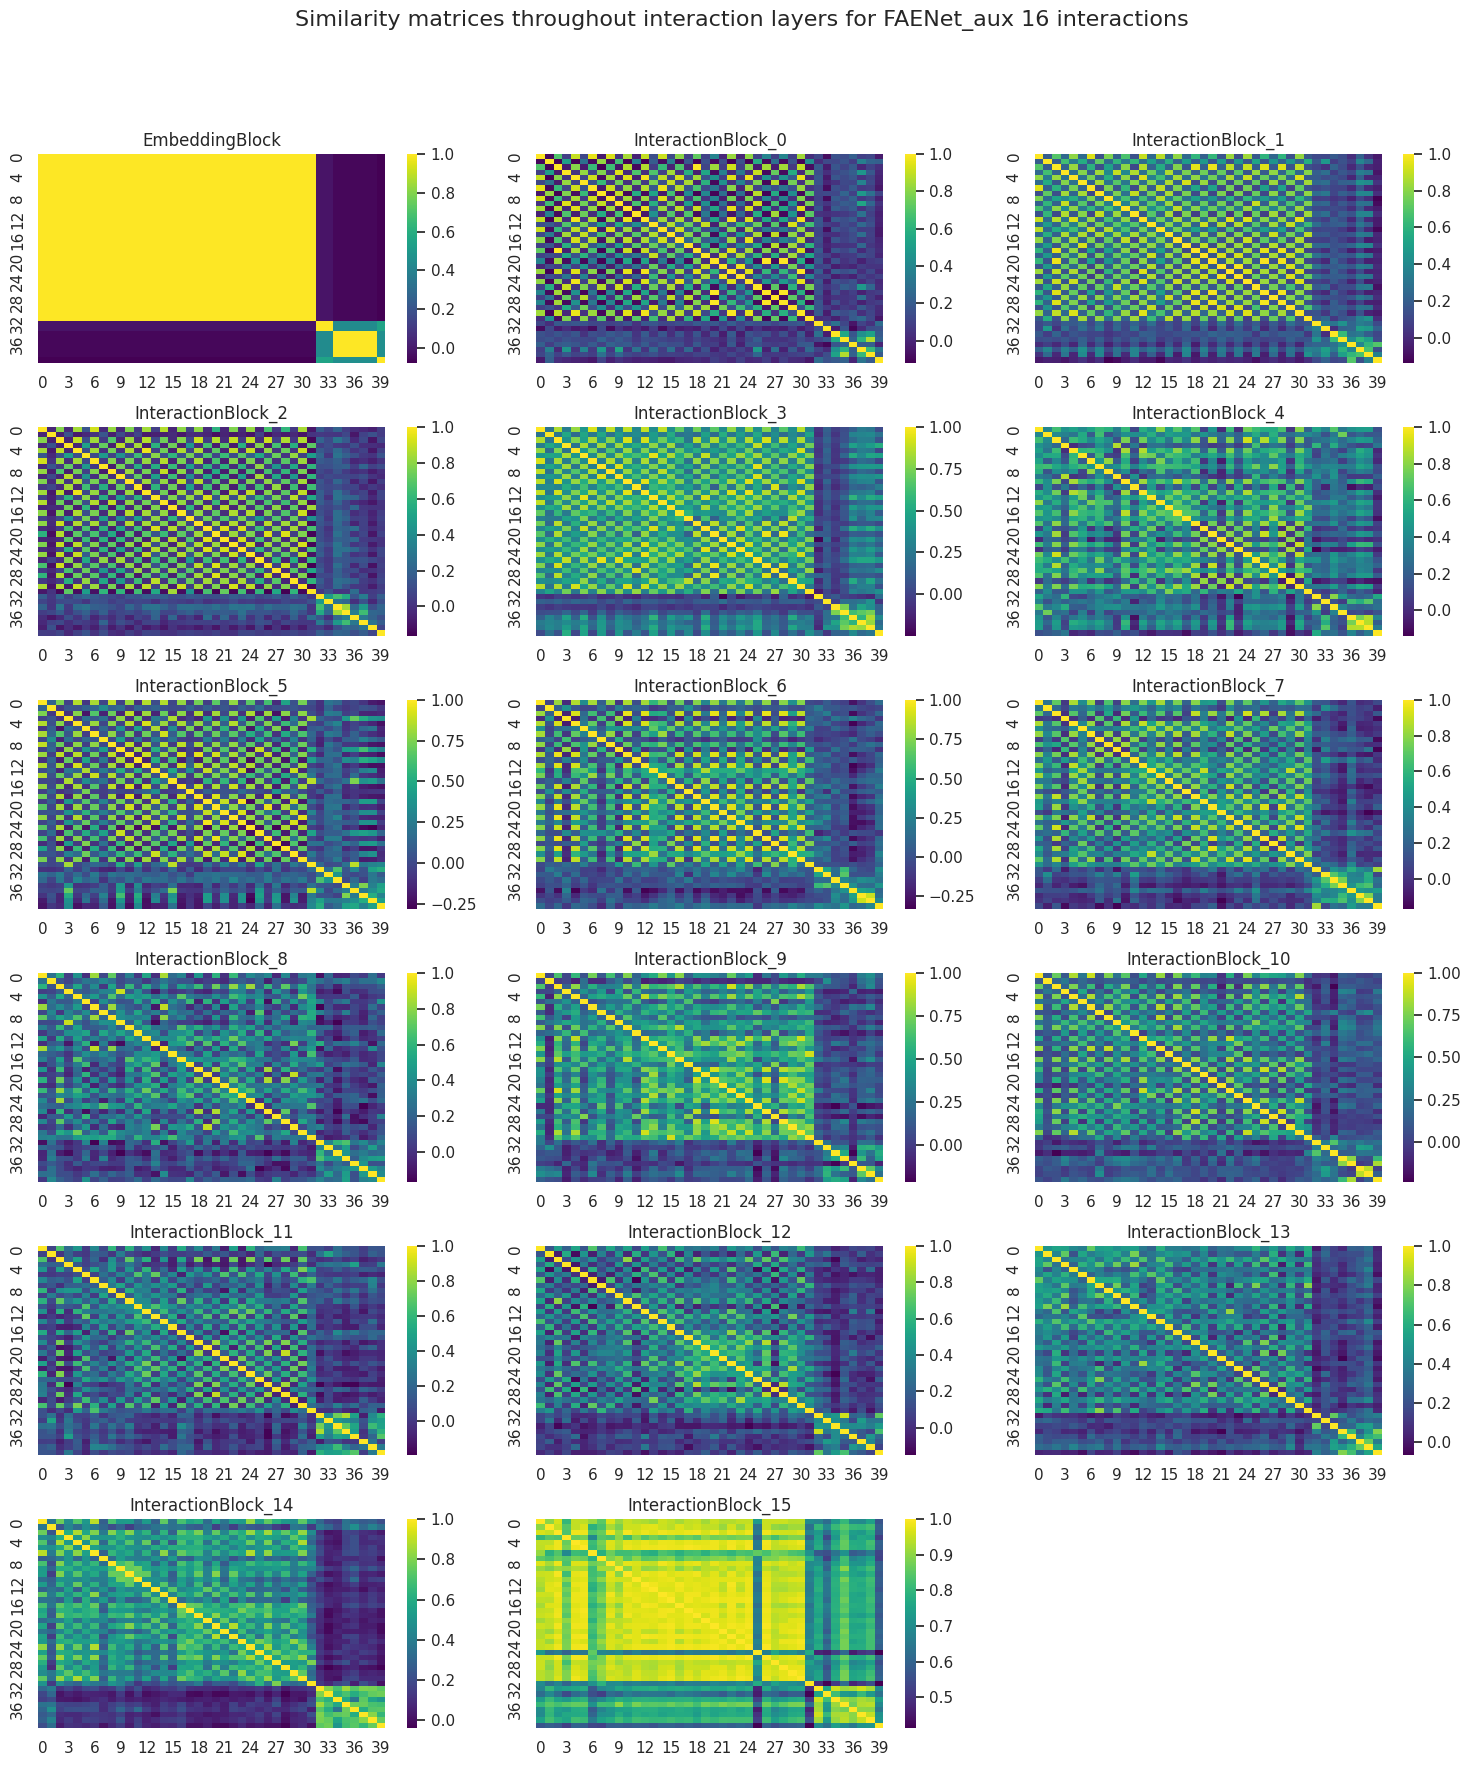

In [67]:
plot_similarity_matrix(activations_dict_faenet_aux_8i, title="FAENet_aux 8 interactions", type_="base")
plot_similarity_matrix(activations_dict_faenet_aux_10i, title="FAENet_aux 10 interactions", type_="base")
plot_similarity_matrix(activations_dict_faenet_aux_12i, title="FAENet_aux 12 interactions", type_="base")
plot_similarity_matrix(activations_dict_faenet_aux_14i, title="FAENet_aux 14 interactions", type_="base")
plot_similarity_matrix(activations_dict_faenet_aux_16i, title="FAENet_aux 16 interactions", type_="base")

collecting data: 2it [00:00, 16.56it/s]

collecting data: 100it [00:04, 21.14it/s]


blocks ['InteractionBlock_0', 'InteractionBlock_1', 'InteractionBlock_2', 'InteractionBlock_3', 'InteractionBlock_4', 'InteractionBlock_5', 'InteractionBlock_6', 'InteractionBlock_7']
mad_values [0.78393143, 0.814119, 0.7966685, 0.7867784, 0.78107363, 0.73618996, 0.7189762, 0.1019928]


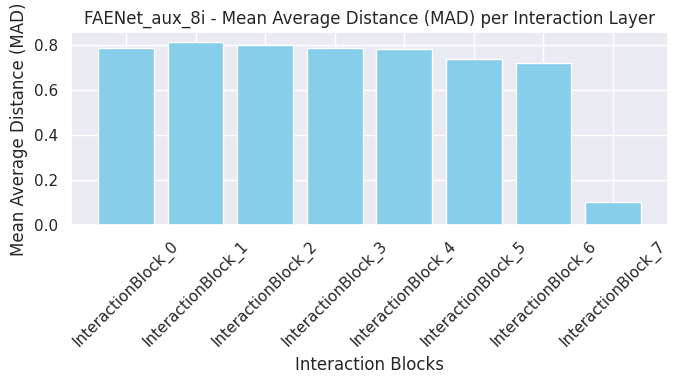

collecting data: 100it [00:03, 30.62it/s]


blocks ['InteractionBlock_0', 'InteractionBlock_1', 'InteractionBlock_2', 'InteractionBlock_3', 'InteractionBlock_4', 'InteractionBlock_5', 'InteractionBlock_6', 'InteractionBlock_7', 'InteractionBlock_8', 'InteractionBlock_9']
mad_values [0.7377025, 0.77095693, 0.8015047, 0.82062984, 0.82997185, 0.8129364, 0.78265846, 0.7392838, 0.6034693, 0.14217518]


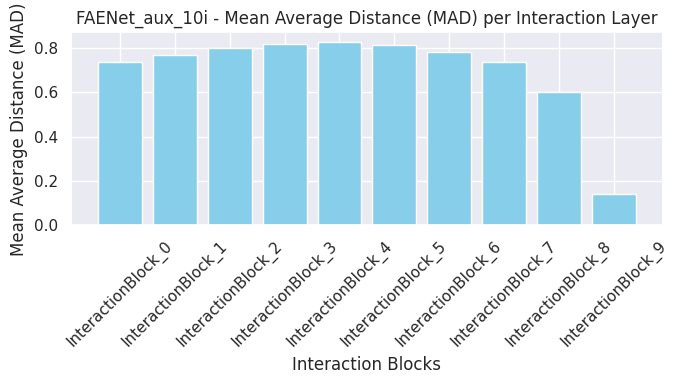

collecting data: 100it [00:03, 28.71it/s]


blocks ['InteractionBlock_0', 'InteractionBlock_1', 'InteractionBlock_2', 'InteractionBlock_3', 'InteractionBlock_4', 'InteractionBlock_5', 'InteractionBlock_6', 'InteractionBlock_7', 'InteractionBlock_8', 'InteractionBlock_9', 'InteractionBlock_10', 'InteractionBlock_11']
mad_values [0.6982416, 0.67608947, 0.7918409, 0.681218, 0.797268, 0.8446608, 0.80690825, 0.80671966, 0.783131, 0.7193897, 0.63211626, 0.043193903]


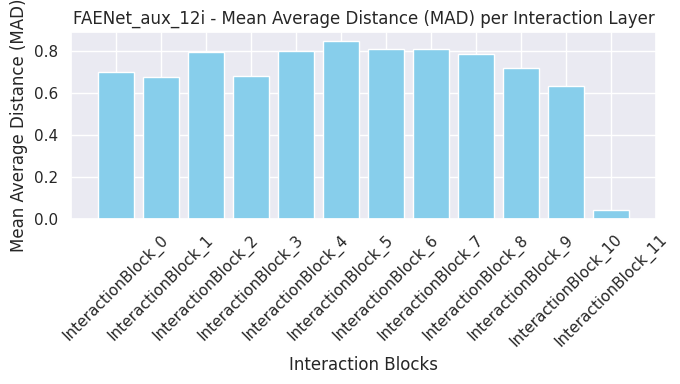

collecting data: 100it [00:03, 27.03it/s]


blocks ['InteractionBlock_0', 'InteractionBlock_1', 'InteractionBlock_2', 'InteractionBlock_3', 'InteractionBlock_4', 'InteractionBlock_5', 'InteractionBlock_6', 'InteractionBlock_7', 'InteractionBlock_8', 'InteractionBlock_9', 'InteractionBlock_10', 'InteractionBlock_11', 'InteractionBlock_12', 'InteractionBlock_13']
mad_values [0.71159196, 0.7161493, 0.67093855, 0.81537074, 0.62732184, 0.78498214, 0.79122734, 0.8153882, 0.8098499, 0.79396665, 0.76968735, 0.71465075, 0.5947819, 0.097964674]


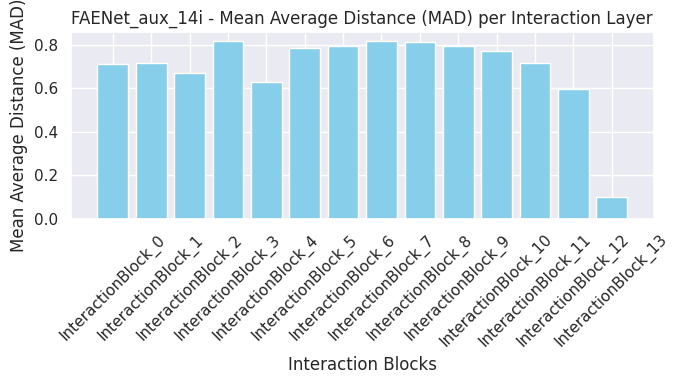

collecting data: 100it [00:03, 25.18it/s]


blocks ['InteractionBlock_0', 'InteractionBlock_1', 'InteractionBlock_2', 'InteractionBlock_3', 'InteractionBlock_4', 'InteractionBlock_5', 'InteractionBlock_6', 'InteractionBlock_7', 'InteractionBlock_8', 'InteractionBlock_9', 'InteractionBlock_10', 'InteractionBlock_11', 'InteractionBlock_12', 'InteractionBlock_13', 'InteractionBlock_14', 'InteractionBlock_15']
mad_values [0.7854318, 0.70048165, 0.7888874, 0.7307398, 0.6515879, 0.79780257, 0.8496216, 0.7383621, 0.79787576, 0.7756527, 0.8267618, 0.8007989, 0.78405786, 0.6887539, 0.56191486, 0.10205967]


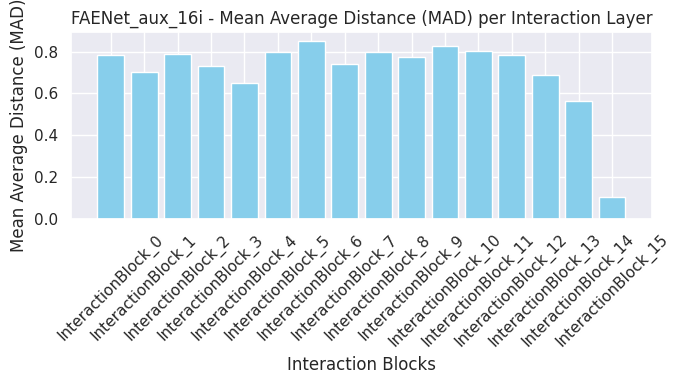

In [68]:
plot_mad_interactions(trainer_faenet_aux_8i, activations_dict_faenet_aux_8i, nb_batches=num_batches_MAD, title="FAENet_aux_8i", type_="base")
plot_mad_interactions(trainer_faenet_aux_10i, activations_dict_faenet_aux_10i, nb_batches=num_batches_MAD, title="FAENet_aux_10i", type_="base")
plot_mad_interactions(trainer_faenet_aux_12i, activations_dict_faenet_aux_12i, nb_batches=num_batches_MAD, title="FAENet_aux_12i", type_="base")
plot_mad_interactions(trainer_faenet_aux_14i, activations_dict_faenet_aux_14i, nb_batches=num_batches_MAD, title="FAENet_aux_14i", type_="base")
plot_mad_interactions(trainer_faenet_aux_16i, activations_dict_faenet_aux_16i, nb_batches=num_batches_MAD, title="FAENet_aux_16i", type_="base")

### Plotting predicted graph

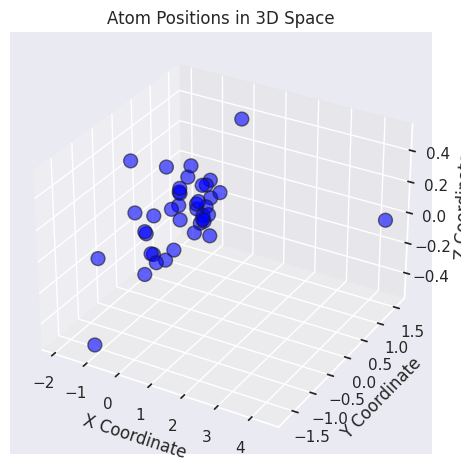

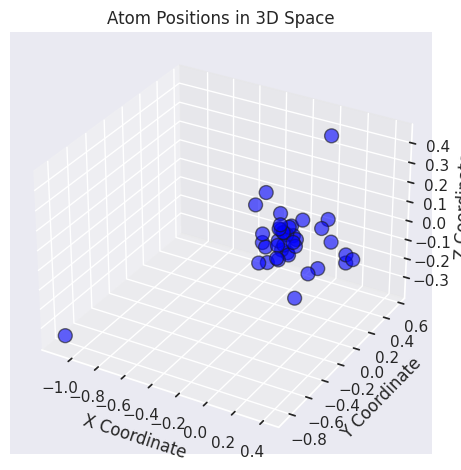

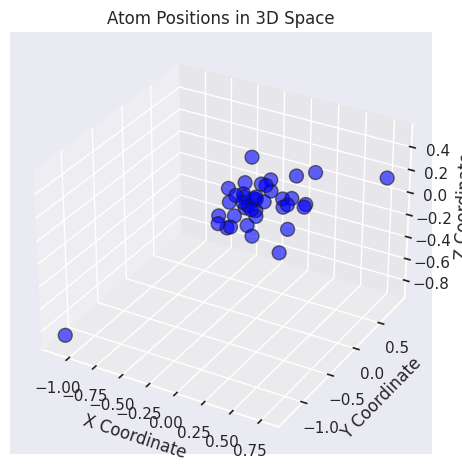

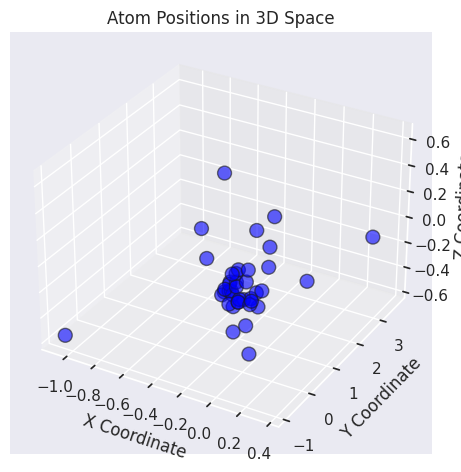

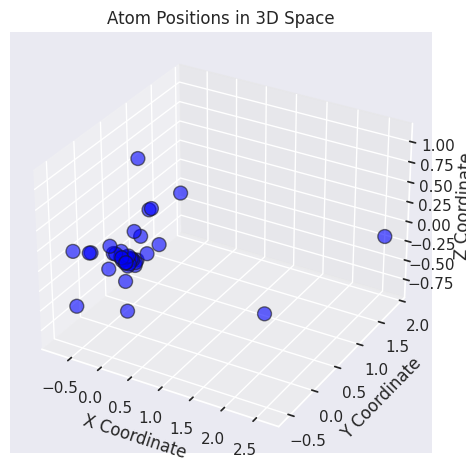

In [69]:
# print(output_faenet_aux_8i)
# print(len(output_faenet_aux_8i))
pred_positions_faenet_aux_8i = output_faenet_aux_8i['positions']
plot_atom_positions(pred_positions_faenet_aux_8i)

pred_positions_faenet_aux_10i = output_faenet_aux_10i['positions']
plot_atom_positions(pred_positions_faenet_aux_10i)

pred_positions_faenet_aux_12i = output_faenet_aux_12i['positions']
plot_atom_positions(pred_positions_faenet_aux_12i)

pred_positions_faenet_aux_14i = output_faenet_aux_14i['positions']
plot_atom_positions(pred_positions_faenet_aux_14i)

pred_positions_faenet_aux_16i = output_faenet_aux_16i['positions']
plot_atom_positions(pred_positions_faenet_aux_16i)